This project refers to an online retailer/wholesaler that sells through an e-commerce platform. The aim is to create a VIP club for important customers with access to extra perks. Customers will be selected according to the frequency and amount they buy. This program will be called “Insiders”. Using advanced data manipulation techniques, customers will be grouped(clustered) according to similarities.




**Solution Planning (IoT)**

**Input**  

    - Business Problem: Select the most valuable customers to join a loyalty program.  
    - Dataset: E-commerce online sales.  
**Output**  

    1.List of customers who will join the Insiders program.  
    2.Answer questions  
    1.Who are the people eligible to join the Insiders program?  
    2.How many customers will be part of the group?  
    3.What are characteristics of these customers?  
    4.What is the percentage of revenue contribution coming from the Insiders?  
    5.What is the expected revenue of this group for the next months?  
**Tasks**  
    1.Segment customers eligible to join the Insiders program  
    •	What is being eligible? What are the most valuable customers?  
    •	Revenue:  
    
    - High average ticket  
    - High LTV (Life Time Value)  
    - Low Recency (last time of purchase)  
    - Big basket size  
    - Low churn probability  
   •   Cost:  
    
    - Low return rate  
2. How many customers will be part of the group?  
Total number of customers vs% of Insiders Group  
3. What are the main characteristics of these customers?  
•	Clustering attributes  
4. What is the percentage of revenue contribution coming from the Insiders?  
•	Anual total revenue  
•	Insiders' revenue  
5. What is the expected revenue of this group for the next months?  
•	Insiders' LTV
•	Cohort Analysis
•	Timeseries (ARIMA, ARMA, Prophet)
6. What actions can the marketing team take to increase revenue?  
•	Discount  
•	Shipping  
•	Company visit  
•	Perks  

**Benchmark guide: RFM Model:**

![RFM Model](./rfm.png)

The goal is to extract clusters that best fit the RFM(Recency, Frequency, Monetary) model.




## Imports

In [110]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import umap.umap_ as umap

from matplotlib import pyplot as plt
from IPython.display import HTML

from pandas_profiling import ProfileReport

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from plotly import express as px
from sklearn import decomposition as dd
from sklearn import ensemble as en
from sklearn import mixture as mx
from sklearn.neighbors import NearestNeighbors

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24,9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Load dataset

In [3]:
df_raw = pd.read_csv('../data/raw/data.csv')

In [4]:
df_raw.shape

(541909, 9)

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [6]:
df_raw.drop('Unnamed: 8',axis = 1, inplace = True)
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# Data Description

In [7]:
df1 = df_raw.copy()

## Columns Rename

In [8]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [9]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price','customer_id', 'country']

df1.columns = cols_new

## Data Dimensions

In [10]:
print(f'Number of Rows:{df1.shape[0]}')
print(f'Number of Columns:{df1.shape[1]}')

Number of Rows:541909
Number of Columns:8


## Data types

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object


## Check NA

In [12]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

**135.080 customers id.... 'missing'**

## Filling NAs

Split dataset into missing vs not_missing:

In [13]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]
df_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,29-Nov-16,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,NaN,United Kingdom


In [14]:
df_not_missing.shape

(406829, 8)

In [15]:
df_missing.shape

(135080, 8)

In [16]:
# missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
# missing_invoice[0:10]

In [17]:
# df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :].head()

In [18]:
# Decision:
# each NAN customer ID will be a new single customer time purchase, just for training(?)

# Create Reference:
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1) # linspace or arrange

# merging original w/ reference df:
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how = 'left')

# need to keep columns...
# Coalesce:
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop aux columns
df1 = df1.drop(columns=['customer_id_x','customer_id_y'])
df1.isna().sum()



invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [19]:
# Removing NAs
df1 = df1.dropna(subset =['description','customer_id'])
print('Removed data: {:.2f}'.format(1 - (df1.shape[0] / df_raw.shape[0])))

Removed data: 0.00


In [20]:
df1.shape

(540455, 8)

In [21]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## Change dtypes

In [22]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [23]:
df1['customer_id'] = df1['customer_id'].astype(int)

In [24]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y' )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [25]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## Descriptive Statistics

In [26]:
# doing the model first, then come back - clustering as a mean, not an end.

In [27]:
num_attributes = df1.select_dtypes(include =['int64','float64', 'int32'])
cat_attributes = df1.select_dtypes(exclude =['int64','float64', 'int32'])

### Numerical Attributes

In [28]:
# central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion - std dev, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

merged = pd.concat([ct1,ct2,d1,d2,d3,d4,d5,d6])
merged['index'] = ['Mean','Median', 'Std', 'Min','Max','Range','Skew','Kurtosis']
merged.set_index('index', inplace = True)
merged.T


index,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
quantity,9.603129,3.00,218.007397,-80995.00,80995.0,161990.00,-0.281253,120252.449063
unit_price,4.623519,2.08,96.889538,-11062.06,38970.0,50032.06,186.257919,58848.017575
customer_id,16678.153600,16241.00,2907.570262,12346.00,22709.0,10363.00,0.493600,-0.792496


1. Min for quantity is negative.
2. Unity Price 0.0 ? free item?


### Categorical Attributes

In [29]:
#number of invoices with letters:
number_invs = len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search( '[^0-9]+', x))), 'invoice_no'].drop_duplicates())
print(f'Invoices with letters: {number_invs}')

#number of stock codes with letters:
number_stk = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search( '[^0-9]+', x))), 'stock_code'].drop_duplicates())
print(f'Stock Codes with letters: {number_stk}')

only_letters_unique_stock_code = cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x ) ) ), 'stock_code' ].unique()
print(f'Unique stock codes with only letters: {only_letters_unique_stock_code}')

Invoices with letters: 3839
Stock Codes with letters: 1073
Unique stock codes with only letters: ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK']


In [30]:
cat_attributes.sample(1)

,invoice_no,stock_code,description,invoice_date,country
221085,556237,DOT,DOTCOM POSTAGE,2017-06-07,United Kingdom


In [31]:
# some further investigation...
# df1.loc[df1['description'] == 'RED RETROSPOT PEG BAG'].sort_values('customer_id').reset_index()

# df1.loc[df1['invoice_no'] == 'C548995']

In [32]:
df1.sample(1)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
303297,563538,21381,MINI WOODEN HAPPY BIRTHDAY GARLAND,2,2017-08-15,1.69,United Kingdom,17841


#### Invoice No

In [33]:
# There are invoices with letters
df_invoices_w_letters = df1.loc[df1['invoice_no'].apply(lambda x: bool (re.search('[^0-9]+', x))),:]

print('Total number of invoices w/ letters')
print(len(df_invoices_w_letters))

# Are all invoices that start with letters 'negative quantity' one?
print('Total number of invoices w/ letters with negative quantity')
print(len(df_invoices_w_letters[df_invoices_w_letters['quantity'] <0]))

# Yes, all invoices starting with letters are negative quantity.

Total number of invoices w/ letters
9291
Total number of invoices w/ letters with negative quantity
9288


#### Stock Code

In [34]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))),'stock_code'].unique()   

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

**To do:**  
Remove Stock_codes in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']  
New stock_Codes after joining missing data ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm',   'DCGSSBOY',        'DCGSSGIRL', 'PADS', 'B', 'CRUK']
 

#### Description

In [35]:
# Todo - delete description

#### Country

In [36]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [37]:
# df1['country'].value_counts(normalize = True).head(4)

In [38]:
# df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False).head()

In [39]:
# %who_ls DataFrame 


# Data Filtering

In [40]:
# df3 = df_ref.copy()
df2 = df1.copy()

Makes sense to filter some data: negative quantity values, assuming returns in the table.

2 ways - 
- exclude what has been returned, like customer had never bought the product
- other way to create new feature based on returns. - Return feature would be beneficial to score clients?

In [41]:
df1.loc[df1['unit_price'] > 0.0, ['customer_id', 'description', 'unit_price']].sort_values('unit_price', ascending = True).head(10)
# df1[['customer_id', 'description', 'unit_price']].sort_values('unit_price', ascending = True).head(10))


,customer_id,description,unit_price
157195,13952,PADS TO MATCH ALL CUSHIONS,0.001
279045,15618,PADS TO MATCH ALL CUSHIONS,0.001
361741,13405,Bank Charges,0.001
359871,16198,PADS TO MATCH ALL CUSHIONS,0.001
108088,16422,Discount,0.010
182729,12901,Discount,0.030
355050,16422,Manual,0.030
4287,15838,ROTATING SILVER ANGELS T-LIGHT HLDR,0.030
362028,16629,POPART WOODEN PENCILS ASST,0.040
303023,16488,POPART WOODEN PENCILS ASST,0.040


In [42]:
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [43]:
# Numerical Attributes
# unit price > 0
df2 = df2.loc[df2['unit_price'] >= 0.04, :]  # there are products that price is 0.001

# Categorical Attributes
# stock code != [POST, D, M, DOT, CRUK]  
# New ones ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
#df2 = df2[~df2['stock_code'].isin(['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK'])]  # removing these products...
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]  # removing these products...


# Description - drop it
df2 = df2.drop(columns = 'description', axis = 1)

# Countries
# remove not specific like EU, and unspecified.

df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity - assuming negative numbers are returns.
df2_returns = df2.loc[df2['quantity'] < 0,:]
df2_purchase = df2.loc[df2['quantity'] > 0,:]


# df2.loc[df2['quantity'] < 0,:].sort_values(['customer_id','description']).head()

# Feature Engineering

In [44]:
# Moving Average 7d,14d,30d...

In [45]:
df3 = df2.copy()

## Feature Creation

In [46]:
# data referencing
df_ref = df3.drop(['invoice_no','stock_code',
                   'quantity','invoice_date','unit_price',
                   'country'], axis = 1).drop_duplicates(ignore_index = True)
df_ref.head()

# Gross Revenue ( qtt * price)
# Recency - latest purchase data for customer
# Frequency - how many products client bought in one year period

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### Gross Revenue

In [47]:
# Gross Revenue:
df2_purchase.loc[:,'gross_revenue'] = df2_purchase.loc[:,'quantity'] * df2_purchase.loc[:,'unit_price']

# # Monetary:
df_monetary = df2_purchase.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how = 'left', on = 'customer_id')
df_ref.isna().sum()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


customer_id       0
gross_revenue    91
dtype: int64

### Recency - Days since last purchase

In [48]:
# Recency - how long has it been since the last puchase.
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days  # using dt, to get int type
df_recency = df_recency[['customer_id','recency_days']].copy()

print('*******Nas before merge:')
print(df_recency.isna().sum())

df_ref = pd.merge(df_ref, df_recency, how = 'left', on = 'customer_id')

print('*******Nas After merge:')
print(df_ref.isna().sum())
# 33 clients never bought anything, onlyu returns... likely data doesn´t comprehend these purchases.

*******Nas before merge:
customer_id     0
recency_days    0
dtype: int64
*******Nas After merge:
customer_id       0
gross_revenue    91
recency_days     91
dtype: int64


### Ammount purchased

In [49]:
# This it just the number of products bought
df_ammt_purchased = df2_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns ={'invoice_no':'invoice_ammt'})
df_ref = pd.merge(df_ref, df_ammt_purchased, how = 'left', on = 'customer_id')
df_ref.isna().sum()
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_ammt
0,17850,5391.21,372.0,34.0
1,13047,3232.59,56.0,9.0
2,12583,6705.38,2.0,15.0
3,13748,948.25,95.0,5.0
4,15100,876.00,333.0,3.0


### Ammount products item  purchased

In [50]:
# This it just the number of products bought
df_ammt_purchased = df2_purchase[['customer_id', 'quantity']].groupby('customer_id').sum().rename(columns = {'quantity':'item_ammt'}).reset_index()
df_ref = pd.merge(df_ref, df_ammt_purchased, how = 'left', on = 'customer_id')
df_ref.isna().sum()
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_ammt,item_ammt
0,17850,5391.21,372.0,34.0,1733.0
1,13047,3232.59,56.0,9.0,1390.0
2,12583,6705.38,2.0,15.0,5028.0
3,13748,948.25,95.0,5.0,439.0
4,15100,876.00,333.0,3.0,80.0


### Ammount different products purchased

In [51]:
# This it just the number of products bought
df_ammt_type_of_prod_purchased = df2_purchase[['customer_id', 'stock_code']].groupby('customer_id').count().rename(columns = {'stock_code':'n_of_dif_products'}).reset_index()
df_ref = pd.merge(df_ref, df_ammt_type_of_prod_purchased, how = 'left', on = 'customer_id')
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
invoice_ammt         91
item_ammt            91
n_of_dif_products    91
dtype: int64

### Average Ticket Value

In [52]:
# Avg Ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_avg_ticket['avg_ticket'] = np.round(df_avg_ticket['avg_ticket'],2 )
df_ref = pd.merge(df_ref, df_avg_ticket, on = 'customer_id', how = 'left')
df_ref.isna().sum()

# df_ref.head()

customer_id           0
gross_revenue        91
recency_days         91
invoice_ammt         91
item_ammt            91
n_of_dif_products    91
avg_ticket           91
dtype: int64

### Average Recency Days

In [53]:
# df2.loc[df2['customer_id'] == 17850,:]

df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'], ascending =['False','False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() #next cx
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next  invoice dt

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis = 1)

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis =1).dropna()

#avg recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

#Merging
df_ref = pd.merge(df_ref, df_avg_recency_days, on ='customer_id', how = 'left' )

df_ref.isna().sum()
# df_aux.dtypes


customer_id             0
gross_revenue          91
recency_days           91
invoice_ammt           91
item_ammt              91
n_of_dif_products      91
avg_ticket             91
avg_recency_days     2816
dtype: int64

In [54]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_ammt,item_ammt,n_of_dif_products,avg_ticket,avg_recency_days
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.15,35.500000
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.90,27.250000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.90,23.187500
3,13748,948.25,95.0,5.0,439.0,28.0,33.87,92.666667
4,15100,876.00,333.0,3.0,80.0,3.0,292.00,8.600000


### Frequency

In [55]:
### Frequency purchase

df2_max = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').max()
df2_min = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').min()
# df2_purchase = df2[['customer_id','invoice_date']].drop_duplicates().groupby('customer_id').count()
df2_purchase.head()

df_aux = ( df2[['customer_id','invoice_no','invoice_date']].drop_duplicates()
                                                           .groupby('customer_id')
                                                           .agg( max_  = ('invoice_date','max'),
                                                                 min_  = ('invoice_date','min'),
                                                                 days_ = ('invoice_date',lambda x: ((x.max() - x.min() ).days) +1  ),
                                                                 buy_  = ('invoice_no', 'count' ) ) ).reset_index()

# frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis = 1 )

# Merging
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on = 'customer_id', how = 'left')
# df_ref.head()
df_ref.isna().sum()

# df_aux.sort_values('frequency', ascending = False).head(20)
# df_aux[df_aux['customer_id'] == 17850].head()

customer_id             0
gross_revenue          91
recency_days           91
invoice_ammt           91
item_ammt              91
n_of_dif_products      91
avg_ticket             91
avg_recency_days     2816
frequency               0
dtype: int64

In [56]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_ammt,item_ammt,n_of_dif_products,avg_ticket,avg_recency_days,frequency
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.15,35.500000,0.486111
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.90,27.250000,0.048780
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.90,23.187500,0.045699
3,13748,948.25,95.0,5.0,439.0,28.0,33.87,92.666667,0.017921
4,15100,876.00,333.0,3.0,80.0,3.0,292.00,8.600000,0.136364


### Number of Returns

In [57]:
df_returns = df2_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtt_returns'})
df_returns['qtt_returns'] = df_returns['qtt_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how = 'left', on ='customer_id')
df_ref.loc[df_ref['qtt_returns'].isna(), 'qtt_returns'] = 0
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
invoice_ammt           91
item_ammt              91
n_of_dif_products      91
avg_ticket             91
avg_recency_days     2816
frequency               0
qtt_returns             0
dtype: int64

### Basket Size - Number of product items per basket  *sum

In [58]:
# invoice (basket) > products > number of total items for all products
# df2_purchase.head()

In [59]:
df_aux =(df2_purchase.loc[:,['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                      .agg(n_purchase = ('invoice_no', 'nunique'), 
                                                                           n_products = ('quantity','sum'))
                                                                      .reset_index() )


df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_basket_size']], how = 'left', on = 'customer_id')
df_ref.isna().sum()
# missing NA´s the ones in 'returns'

customer_id             0
gross_revenue          91
recency_days           91
invoice_ammt           91
item_ammt              91
n_of_dif_products      91
avg_ticket             91
avg_recency_days     2816
frequency               0
qtt_returns             0
avg_basket_size        91
dtype: int64

In [60]:
df2_purchase[df2_purchase['customer_id'] == 12346]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id,gross_revenue
61619,541431,23166,74215,2017-01-16,1.04,United Kingdom,12346,77183.6


### Basket, distinctive items per purchase. *count

In [61]:
# Transaction > product > item ammount

df_aux = (df2_purchase.loc[:,['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                       .agg(n_purchase = ('invoice_no', 'nunique'), 
                                                                            n_products = ('quantity','nunique'))
                                                                       .reset_index() )

df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_unique_basket_size']], how = 'left', on = 'customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
invoice_ammt                91
item_ammt                   91
n_of_dif_products           91
avg_ticket                  91
avg_recency_days          2816
frequency                    0
qtt_returns                  0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

Check if returns will remain in df_ref:

In [62]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_ammt,item_ammt,n_of_dif_products,avg_ticket,avg_recency_days,frequency,qtt_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.15,35.500000,0.486111,40.0,50.970588,0.176471
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.90,27.250000,0.048780,35.0,154.444444,1.222222
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.90,23.187500,0.045699,50.0,335.200000,1.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.87,92.666667,0.017921,0.0,87.800000,1.600000
4,15100,876.00,333.0,3.0,80.0,3.0,292.00,8.600000,0.136364,22.0,26.666667,0.666667


In [63]:
df_ref.shape

(5787, 12)

# EDA

In [64]:
df4 = df_ref.dropna().copy()

df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
invoice_ammt              0
item_ammt                 0
n_of_dif_products         0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtt_returns               0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## Univariate Analysis

In [65]:
# profile = ProfileReport(df4)
# profile.to_file('output.html')

### Gross Revenue

In [66]:
# df4.sort_values('gross_revenue', ascending = False).head(10)

In [67]:
# df3[df3['customer_id'] == 14646].head()

In [68]:
# np.sum(df3.loc[df3['customer_id'] == 14646,'quantity'] * df3.loc[df3['customer_id']== 14646,'unit_price'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gross_revenue'>

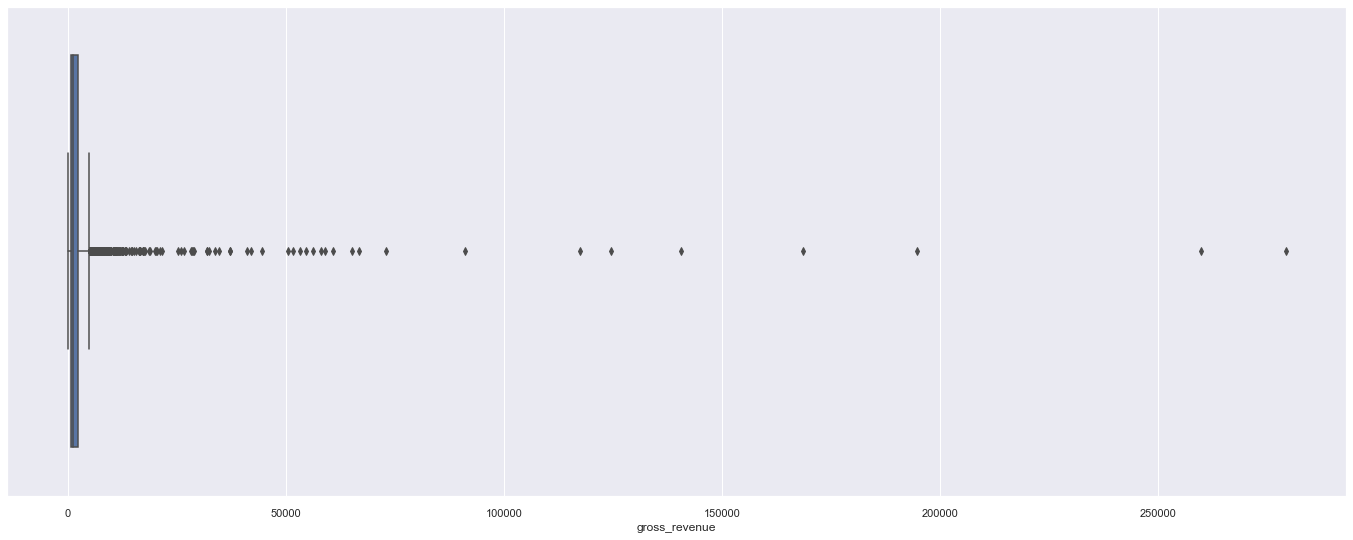

In [69]:
sns.boxplot(df4.gross_revenue)

## Bivariate Analysis

**Low variance on Frequency and Avg. Ticket**

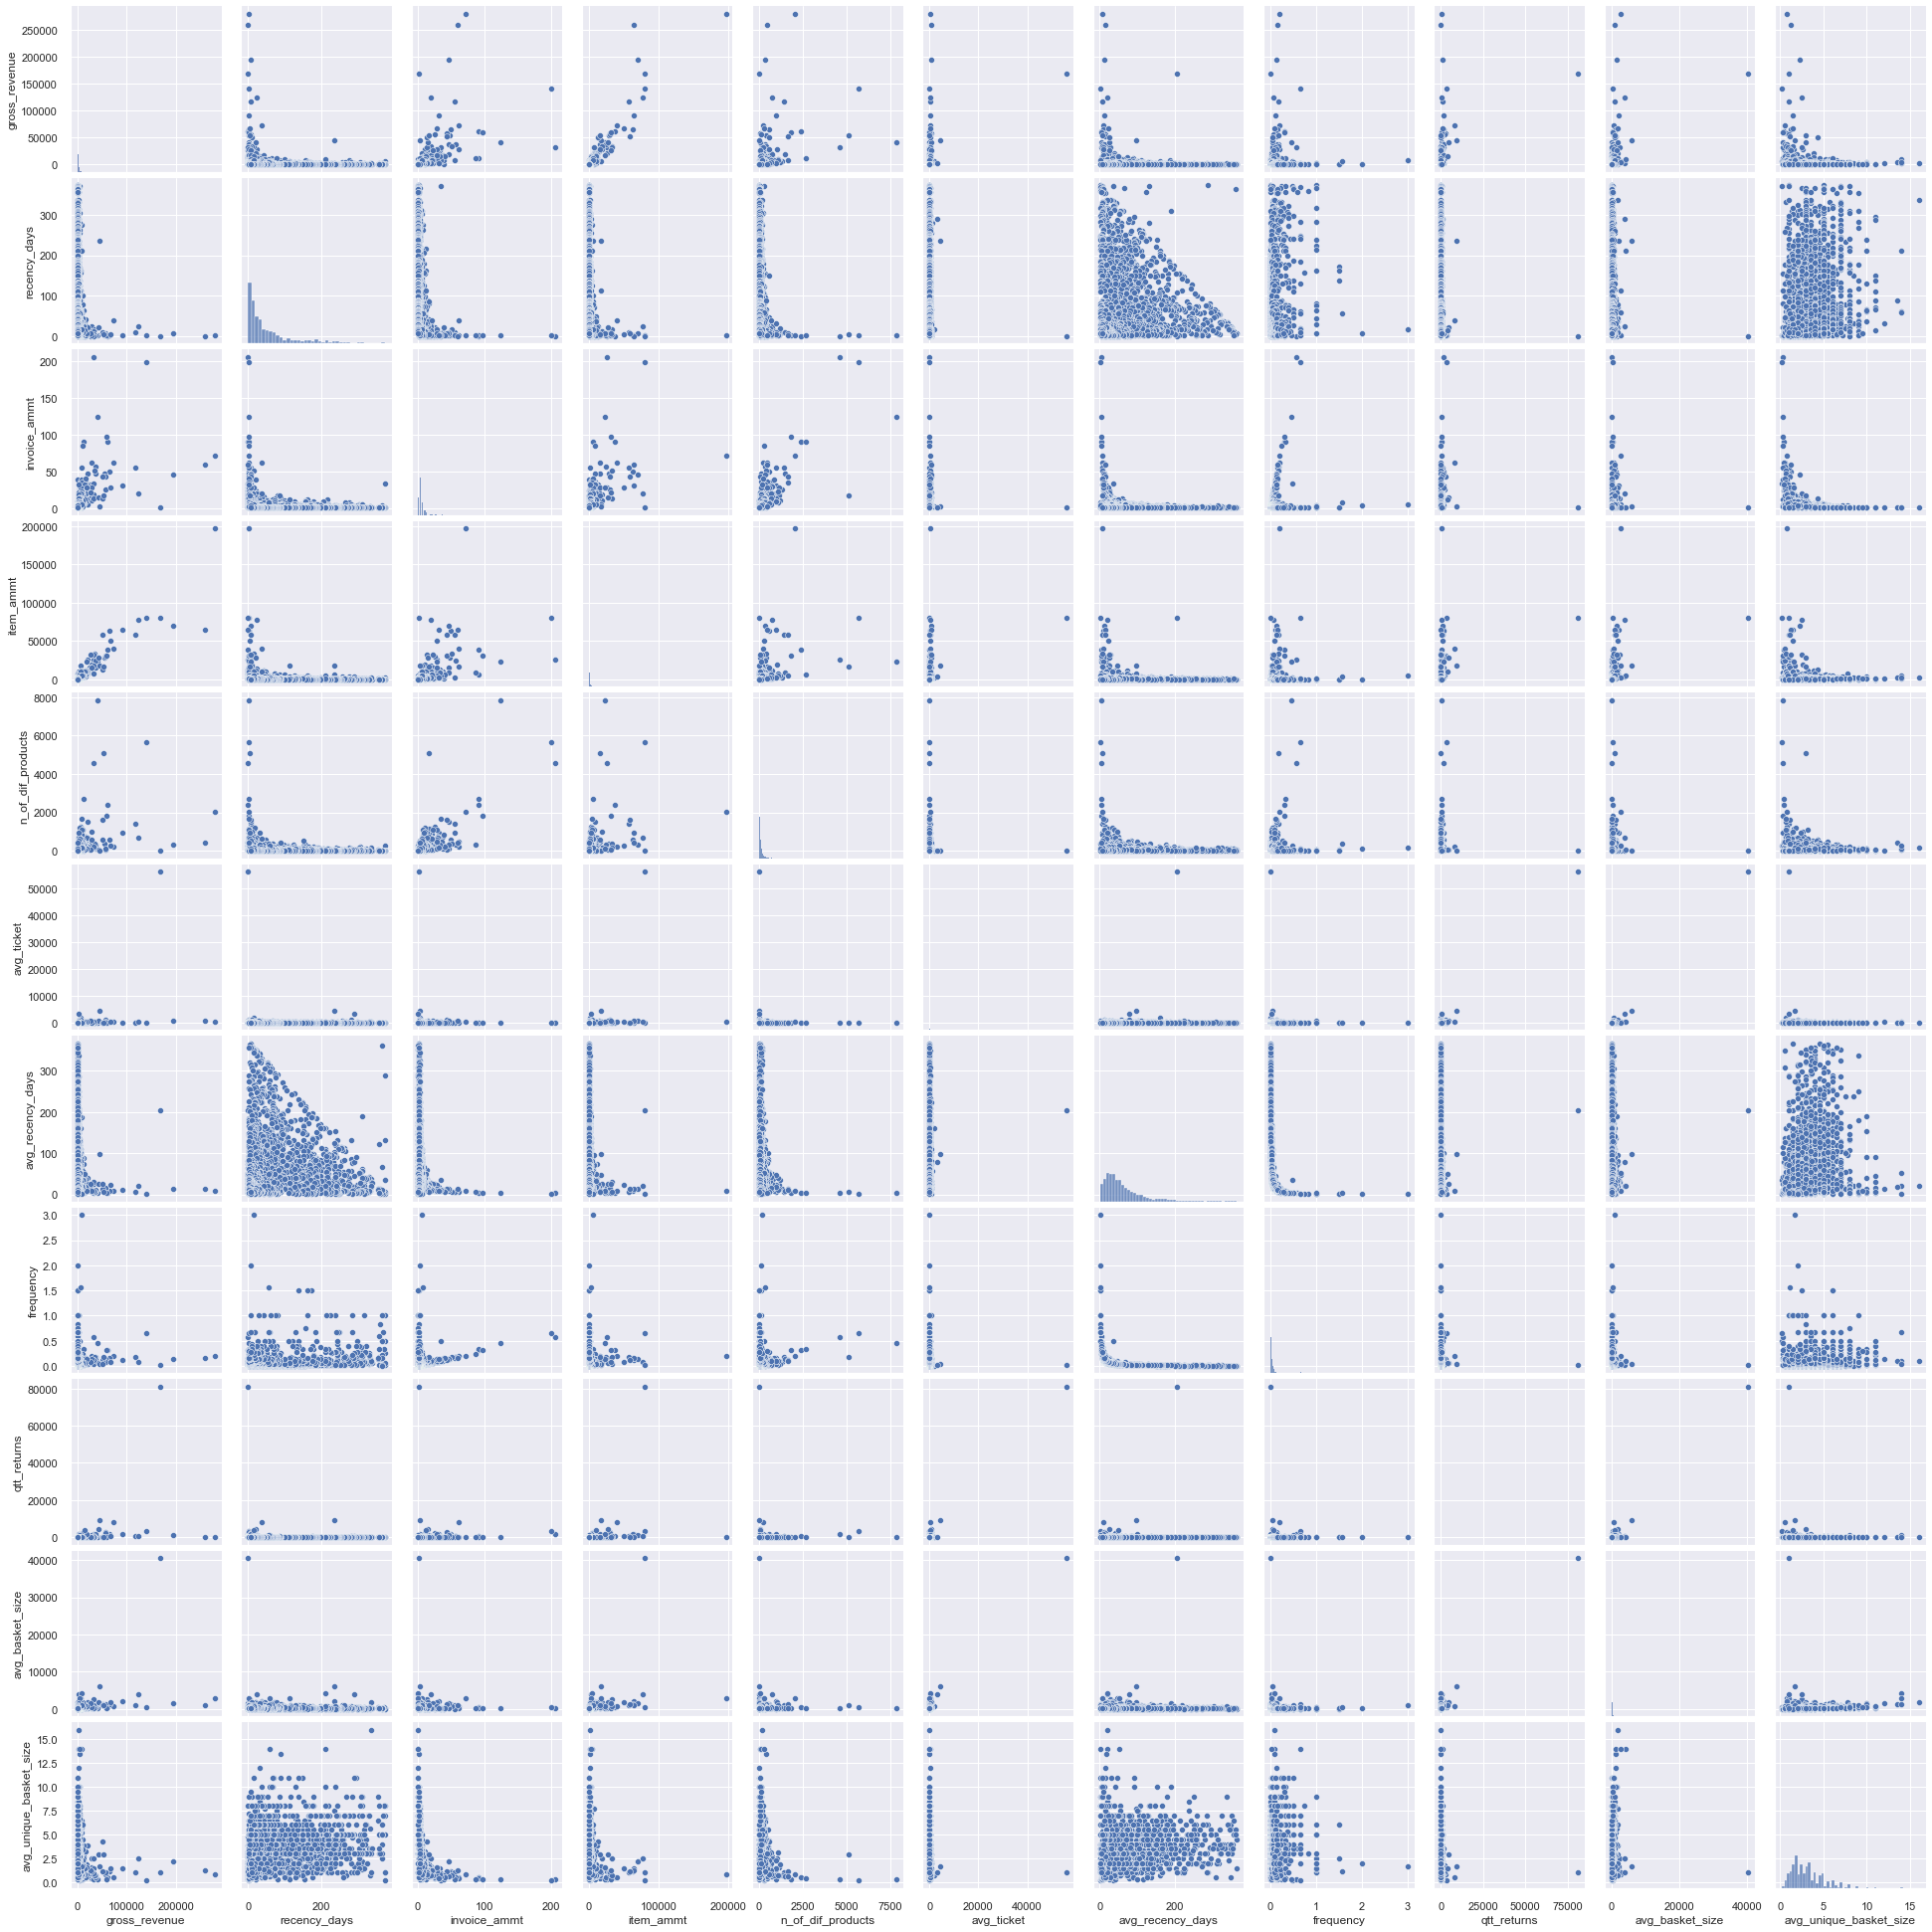

In [70]:
sns.pairplot(df4.drop(columns = 'customer_id'));

## Spatial Study

In [71]:
# full_feat:
df43_full_features = df4.drop(columns = ['customer_id'], axis = 1).copy()

# embedded space:
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'n_of_dif_products', 'frequency', 'qtt_returns']
df43_less_features = df4[cols_selected].copy()
df43_less_features.drop(columns= 'customer_id', inplace = True)
# min-max, standard scales, robust scaler?

In [72]:
# Many features were not useful, so trying modeling with 2 different sets


mm = pp.MinMaxScaler()

df43_full_features['gross_revenue'] = mm.fit_transform(df43_full_features[['gross_revenue']])

# 'customer_id', 
df43_full_features['recency_days']          = mm.fit_transform( df43_full_features[['recency_days']])
df43_full_features['invoice_ammt']          = mm.fit_transform( df43_full_features[['invoice_ammt']])
df43_full_features['item_ammt']             = mm.fit_transform( df43_full_features[['item_ammt']])
df43_full_features['n_of_dif_products']     = mm.fit_transform( df43_full_features[['n_of_dif_products']])
df43_full_features['avg_ticket']            = mm.fit_transform( df43_full_features[['avg_ticket']])
df43_full_features['avg_recency_days']      = mm.fit_transform( df43_full_features[['avg_recency_days']])
df43_full_features['frequency']             = mm.fit_transform( df43_full_features[['frequency']])
df43_full_features['qtt_returns']           = mm.fit_transform( df43_full_features[['qtt_returns']])
df43_full_features['avg_basket_size']       = mm.fit_transform( df43_full_features[['avg_basket_size']])
df43_full_features['avg_unique_basket_size']= mm.fit_transform( df43_full_features[['avg_unique_basket_size']])



df43_less_features['gross_revenue'] = mm.fit_transform(df43_less_features[['gross_revenue']])
# 'customer_id', 
df43_less_features['recency_days']          = mm.fit_transform( df43_less_features[['recency_days']])
# df43_less_features['invoice_ammt']          = mm.fit_transform( df43_less_features[['invoice_ammt']])
# df43_less_features['item_ammt']             = mm.fit_transform( df43_less_features[['item_ammt']])
df43_less_features['n_of_dif_products']     = mm.fit_transform( df43_less_features[['n_of_dif_products']])
# df43_less_features['avg_ticket']            = mm.fit_transform( df43_less_features[['avg_ticket']])
# df43_less_features['avg_recency_days']      = mm.fit_transform( df43_less_features[['avg_recency_days']])
df43_less_features['frequency']             = mm.fit_transform( df43_less_features[['frequency']])
df43_less_features['qtt_returns']           = mm.fit_transform( df43_less_features[['qtt_returns']])
# df43_less_features['avg_basket_size']       = mm.fit_transform( df43_less_features[['avg_basket_size']])
# df43_less_features['avg_unique_basket_size']= mm.fit_transform( df43_less_features[['avg_unique_basket_size']])

df43_less_features.columns

Index(['gross_revenue', 'recency_days', 'n_of_dif_products', 'frequency',
       'qtt_returns'],
      dtype='object')

In [73]:
X_less_features = df43_less_features.copy()
X_full_features = df43_full_features.copy()

In [74]:
df43_full_features.head()

,gross_revenue,recency_days,invoice_ammt,item_ammt,n_of_dif_products,avg_ticket,avg_recency_days,frequency,qtt_returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.160976,0.008799,0.037770,0.000285,0.094521,0.160512,0.000494,0.001234,0.000000
1,0.011559,0.150134,0.039024,0.007056,0.021692,0.000298,0.071918,0.014470,0.000432,0.003789,0.066088
2,0.024000,0.005362,0.068293,0.025538,0.029476,0.000476,0.060788,0.013441,0.000617,0.008252,0.089963
3,0.003375,0.254692,0.019512,0.002225,0.003445,0.000565,0.251142,0.004165,0.000000,0.002143,0.089963
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.005162,0.020822,0.043717,0.000272,0.000634,0.030979


In [75]:
df43_less_features.head()

,gross_revenue,recency_days,n_of_dif_products,frequency,qtt_returns
0,0.019292,0.997319,0.037770,0.160512,0.000494
1,0.011559,0.150134,0.021692,0.014470,0.000432
2,0.024000,0.005362,0.029476,0.013441,0.000617
3,0.003375,0.254692,0.003445,0.004165,0.000000
4,0.003116,0.892761,0.000255,0.043717,0.000272


### PCA - full features

In [76]:
X_full_features.head()

,gross_revenue,recency_days,invoice_ammt,item_ammt,n_of_dif_products,avg_ticket,avg_recency_days,frequency,qtt_returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.160976,0.008799,0.037770,0.000285,0.094521,0.160512,0.000494,0.001234,0.000000
1,0.011559,0.150134,0.039024,0.007056,0.021692,0.000298,0.071918,0.014470,0.000432,0.003789,0.066088
2,0.024000,0.005362,0.068293,0.025538,0.029476,0.000476,0.060788,0.013441,0.000617,0.008252,0.089963
3,0.003375,0.254692,0.019512,0.002225,0.003445,0.000565,0.251142,0.004165,0.000000,0.002143,0.089963
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.005162,0.020822,0.043717,0.000272,0.000634,0.030979


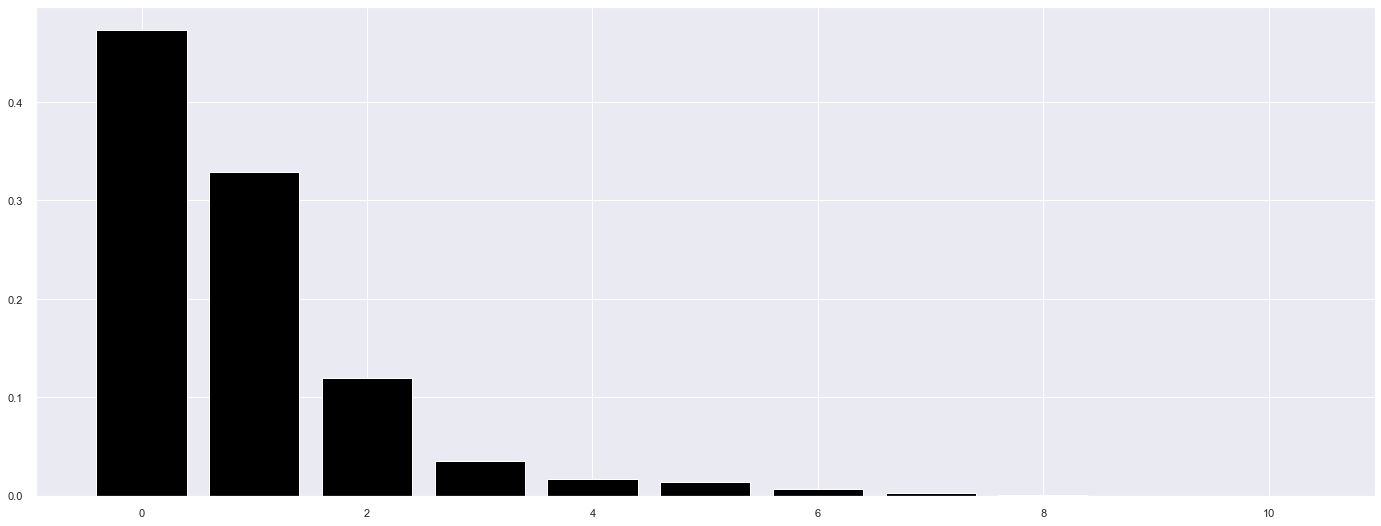

In [77]:

pca = dd.PCA( n_components = X_full_features.shape[1])
principal_component = pca.fit_transform(X_full_features)

# plot explaining variables
features = range ( pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'black')

# PCA COMPONENTS
df_pca = pd.DataFrame(principal_component)

In [78]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.768529,-0.130876,-0.348862,0.110885,0.118556,-0.038639,0.022821,-0.066367,0.004853,0.007498,-0.000221
1,-0.040370,-0.132748,-0.088166,-0.013635,-0.004466,-0.002861,0.002137,0.000264,0.002017,0.000441,0.000358
2,-0.178263,-0.144536,-0.035687,0.017035,-0.007104,-0.007536,-0.000223,-0.012106,-0.005008,0.001917,-0.000209
3,0.056276,0.051371,-0.122651,-0.019899,-0.003234,0.002223,-0.003019,-0.003069,0.000480,-0.000299,-0.000042
4,0.682427,-0.175238,-0.270328,-0.021213,-0.002157,0.008359,-0.000514,0.005620,0.001614,-0.000995,-0.002766


<AxesSubplot:xlabel='0', ylabel='1'>

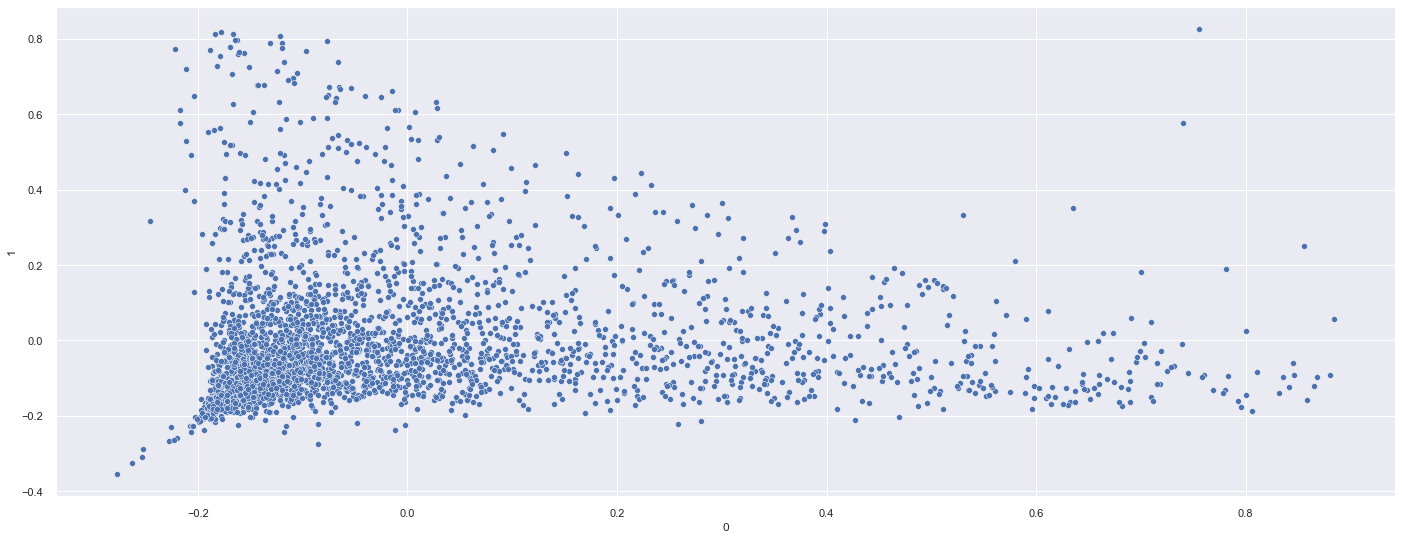

In [79]:
sns.scatterplot(x = 0, y = 1, data = df_pca)

#### PCA - Less Features

In [80]:
X_less_features.head()

,gross_revenue,recency_days,n_of_dif_products,frequency,qtt_returns
0,0.019292,0.997319,0.037770,0.160512,0.000494
1,0.011559,0.150134,0.021692,0.014470,0.000432
2,0.024000,0.005362,0.029476,0.013441,0.000617
3,0.003375,0.254692,0.003445,0.004165,0.000000
4,0.003116,0.892761,0.000255,0.043717,0.000272


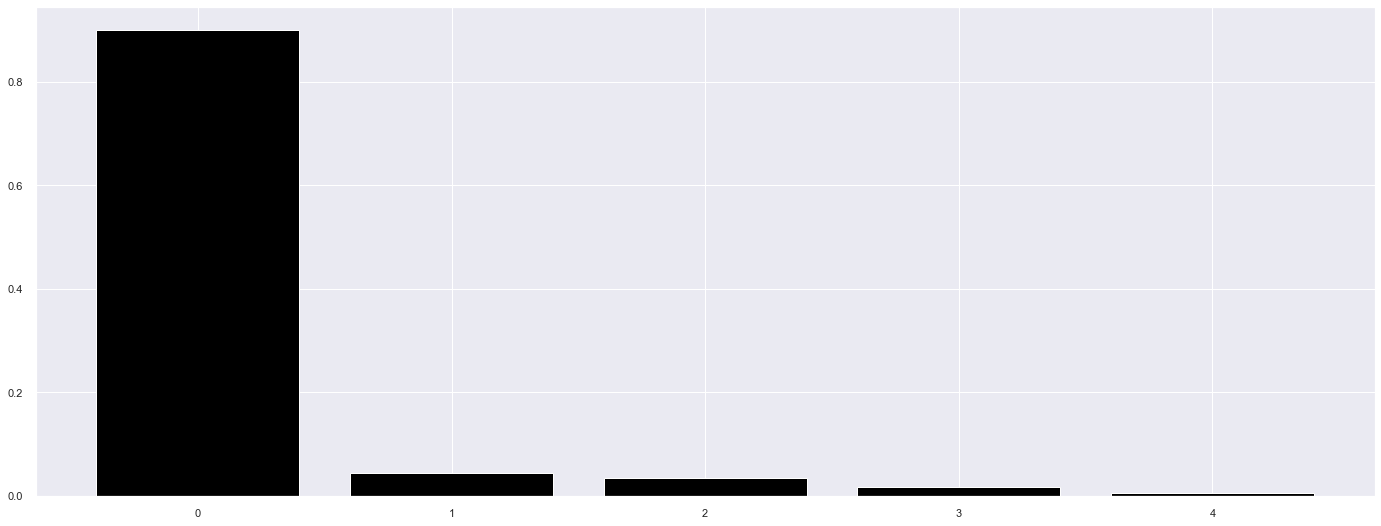

In [81]:
pca = dd.PCA( n_components = X_less_features.shape[1])
principal_components = pca.fit_transform(X_less_features)

# plot explaining variables
features = range ( pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'black')

# PCA COMPONENTS
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

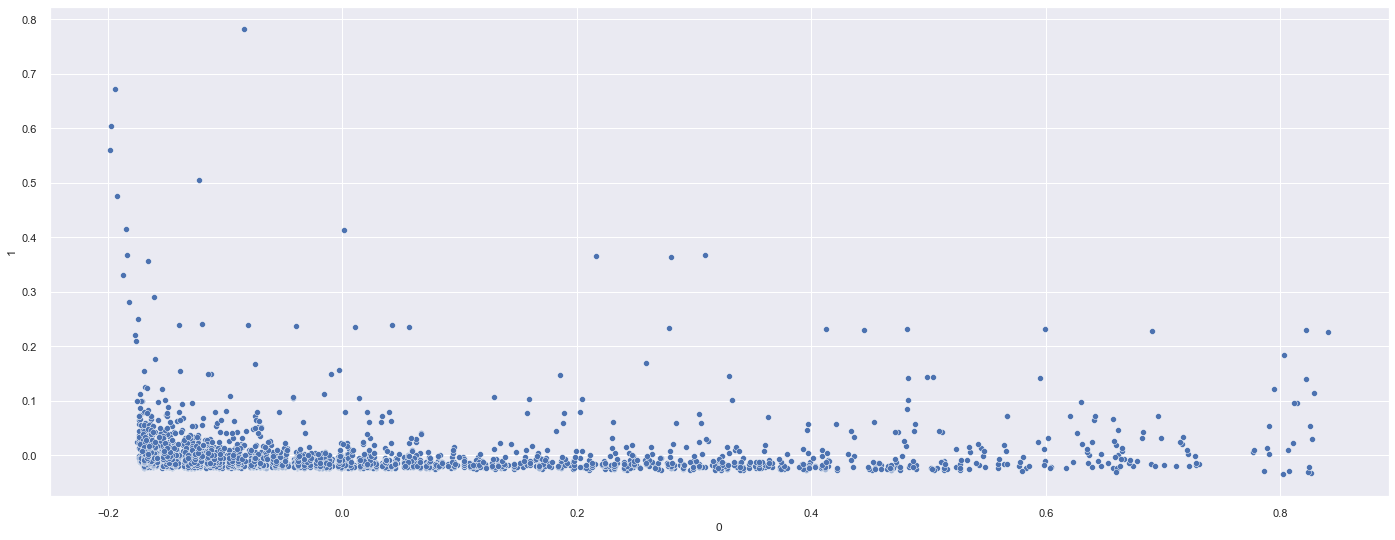

In [82]:
sns.scatterplot( x=0, y=1, data=df_pca )

In [83]:
# no clear spacing

### UMAP - full features

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

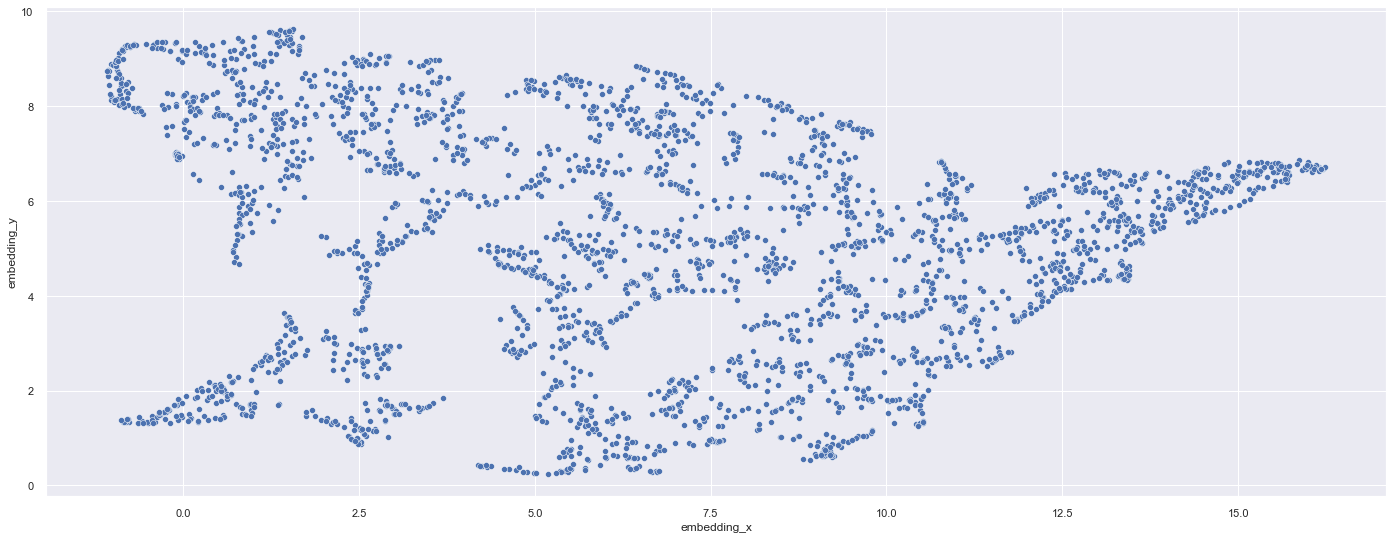

In [84]:
# UMAP
import umap.umap_ as umap
# reducer = umap.UMAP(n_neighbors = 9, random_state = 42)
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(X_full_features)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plotting umap
sns.scatterplot( x = 'embedding_x', y = 'embedding_y', data = df_pca )

#### UMAP - Less features

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

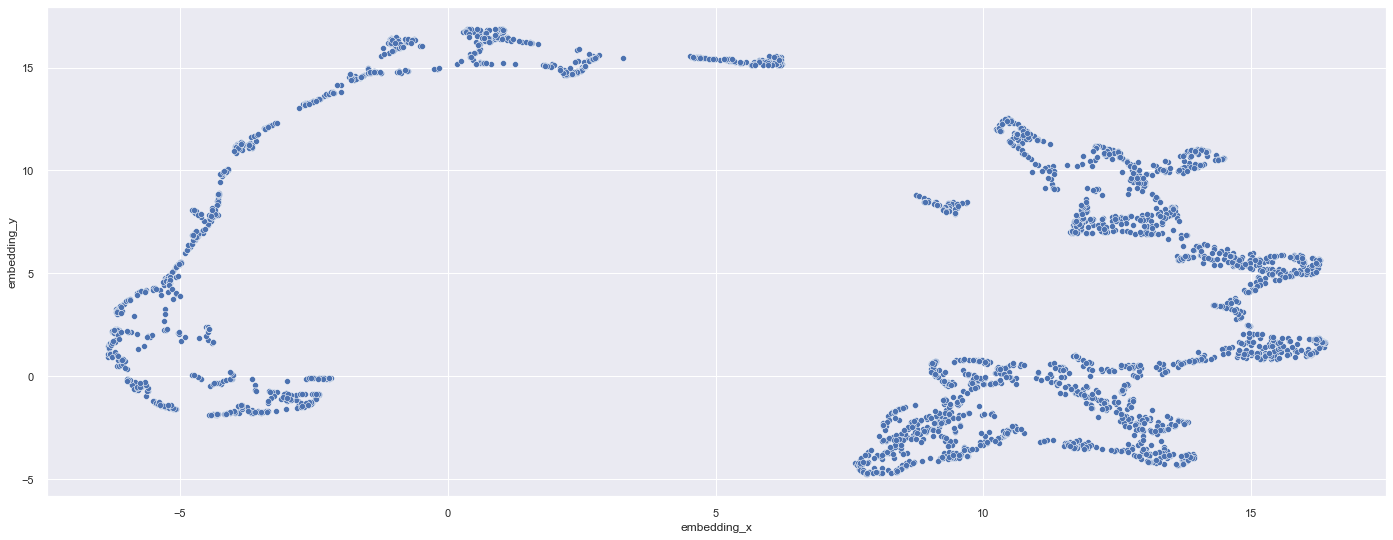

In [85]:
# UMAP

# reducer = umap.UMAP(n_neighbors = 9, random_state = 42)
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(X_less_features)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plotting umap
sns.scatterplot( x = 'embedding_x', y = 'embedding_y', data = df_pca )

In [86]:
# not many groups found

### t-SNE - full features

C:\Users\Fu\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Fu\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

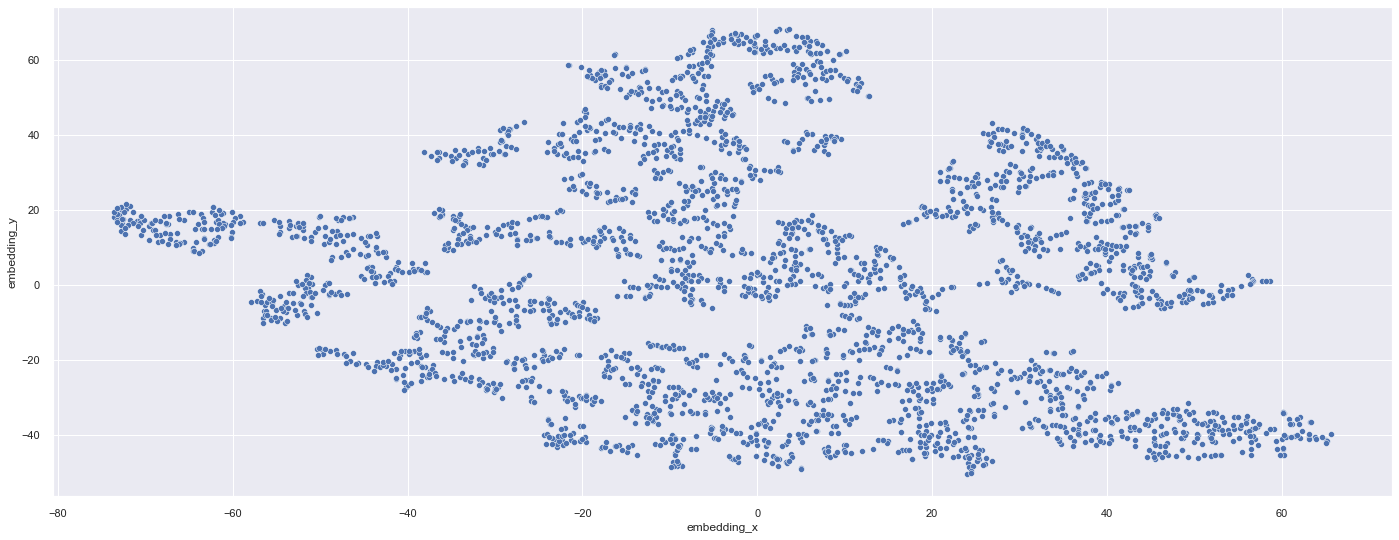

In [87]:
# UMAP
import umap.umap_ as umap
from sklearn.manifold import TSNE
# reducer = umap.UMAP(n_neighbors = 9, random_state = 42)
reducer = TSNE(n_components = 2, random_state = 42, n_jobs = -1)
embedding = reducer.fit_transform(X_full_features)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plotting umap
sns.scatterplot( x = 'embedding_x', y = 'embedding_y', data = df_pca )

### t-SNE - less features

C:\Users\Fu\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Fu\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

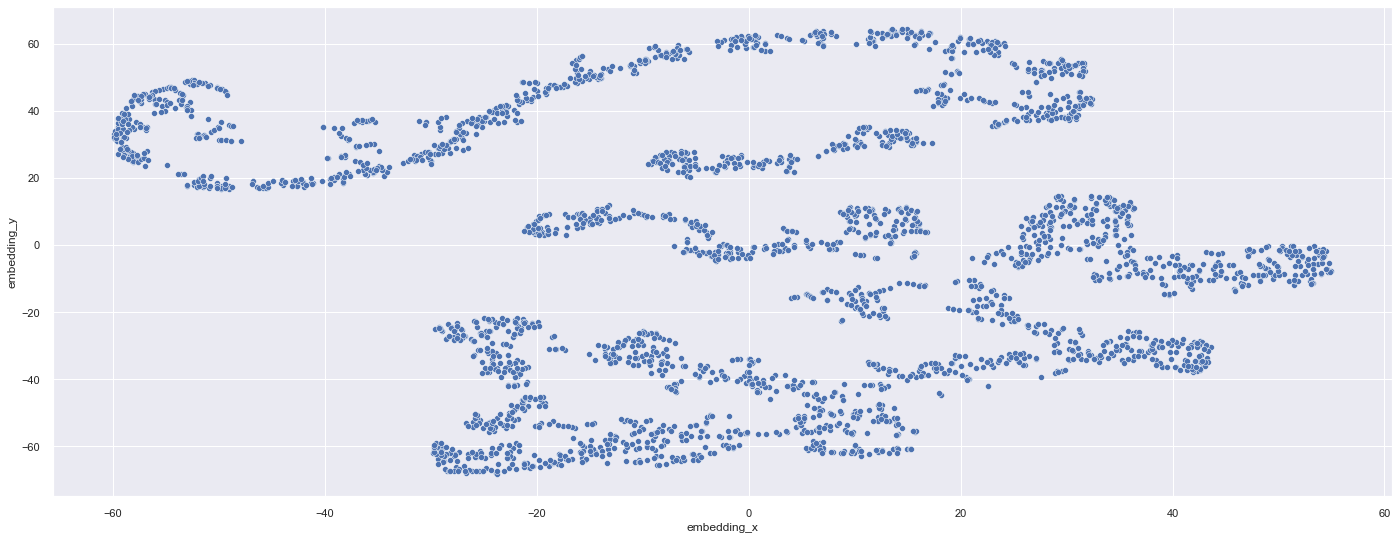

In [88]:
# UMAP
import umap.umap_ as umap
from sklearn.manifold import TSNE
# reducer = umap.UMAP(n_neighbors = 9, random_state = 42)
reducer = TSNE(n_components = 2, random_state = 42, n_jobs = -1)
embedding = reducer.fit_transform(X_less_features)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plotting umap
sns.scatterplot( x = 'embedding_x', y = 'embedding_y', data = df_pca )

### Tree-Based Embedding - v1.0

In [89]:
from sklearn import ensemble as en

In [90]:
df4.head()
X = df4.drop( columns = ['customer_id', 'gross_revenue'], axis = 1 )  # df4 - no transformation applied!!
y = df4['gross_revenue'] # using gross_revenue

# model definition
rf_model = en.RandomForestRegressor( random_state = 42, n_estimators = 100)

# model training
rf_model.fit( X, y)

#leaf
# rf_model.apply( X )  # applying own training data

#dataframe Leag

RandomForestRegressor(random_state=42)

In [91]:
df_leaf = pd.DataFrame(rf_model. apply(X))
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2998,2726,3318,3335,3016,3058,3229,3133,2821,3140,3168,3072,3154,3189,3116,2722,3130,2799,3043,3255,3280,2669,2862,3293,2831,3125,3026,3231,3084,3181,2904,3284,3365,3374,2970,2992,3024,3135,2741,2950,3035,3183,3421,3134,3175,3038,3035,3335,3400,3006,2796,3211,3114,3089,3042,2999,3151,3042,3118,3132,3015,3180,3333,3243,2876,3055,3068,3312,3133,3246,3079,3284,2692,2977,2832,3168,3306,2718,3214,2796,3135,3322,2762,3094,2999,3015,3005,3376,3135,2973,3258,2939,3233,2773,3214,3130,2950,3368,3045,3326
1,2936,3093,3022,2944,3024,3036,2938,2809,2785,3035,3114,3052,3085,3077,2792,2768,2572,2757,2811,2418,3260,2702,2813,2824,3146,3117,2925,2797,3048,3104,2982,3014,2970,2961,2840,2959,2613,2344,2713,2913,2966,2792,2953,3115,3122,2939,3011,2877,3012,2932,2774,3110,3077,2978,3004,2956,2722,2790,3059,3140,2990,2826,2907,3204,2854,2503,2999,2924,2853,2960,2964,2984,2732,2880,2828,2508,2863,2701,3179,2765,3024,2896,2752,2785,2903,3141,2939,2983,3098,2839,2510,2921,2941,2758,3137,3051,2931,2893,2921,2802
2,3490,3616,3578,3400,3594,3618,3529,3546,3687,3614,3576,3590,3535,3629,3517,3552,3555,3648,3601,3477,3482,3652,3610,3518,3599,3597,3489,3630,3512,3705,3451,3682,3653,3627,3580,3635,3532,3531,3593,3478,3657,3399,3654,3618,3492,3590,3580,3676,3645,3605,3576,3495,3621,3619,3666,3664,3611,3649,3543,3408,3603,3618,3590,3683,3389,3630,3614,3641,3592,3611,3584,3428,3588,3512,3613,3554,3584,3541,3570,3601,3521,3452,3547,3538,3603,3621,3611,3690,3546,3394,3588,3465,3564,3505,3615,3570,3574,3616,3586,3659
3,2151,1962,1571,1399,1828,1500,2107,1785,2073,2115,2231,1498,1310,1600,1593,1824,1869,1570,1337,1265,1828,1248,1488,1574,2173,1981,1582,1946,1460,1509,1816,1558,1363,1579,1397,1736,1554,1423,1352,1796,1778,1436,1369,1744,1616,1492,1569,1381,2054,1230,1582,1564,1342,2197,2085,2022,1590,1726,1466,2122,1574,2122,1749,1810,1514,1510,2096,2049,1470,2086,2318,1612,2000,2207,1664,1545,1351,1543,1967,1946,2118,1442,1731,1553,1420,1840,1521,2161,1352,1325,1799,1378,2052,2081,2051,2168,1529,1001,1840,2100
4,217,270,298,592,175,466,725,687,175,165,598,160,688,953,707,712,199,208,586,696,518,703,467,213,646,195,563,535,139,760,702,866,197,337,220,618,434,197,539,589,740,717,451,607,726,547,936,661,703,619,609,965,740,562,563,572,725,208,724,586,229,244,557,188,663,437,568,740,700,600,580,190,603,610,704,345,709,586,599,183,197,332,565,332,587,216,287,852,353,806,414,208,687,576,692,743,575,907,697,207


In [92]:
# each point in the table is the position the customer was assigned to
X.shape

(2969, 10)

In [93]:
df_leaf.shape  # 100 (the 100 estimators)

(2969, 100)

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

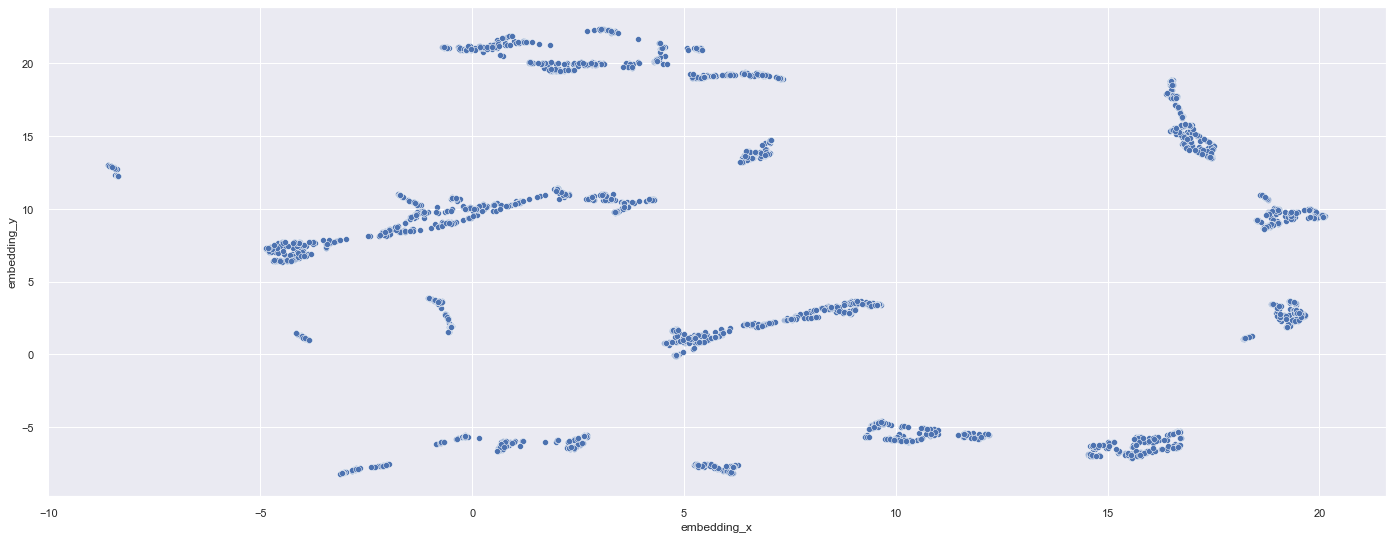

In [94]:
# Reducing dimensionality  # reduce the projection of the 100 columns into 2.
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_leaf)

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]

#plotting
sns.scatterplot(x = 'embedding_x',
               y = 'embedding_y',
               data = df_tree)


#### Tree-Based Embedding - v2.0

In [95]:
df4.head()
X = df4.drop( columns = ['customer_id', 'gross_revenue'], axis = 1 )
y_aux = pd.DataFrame()
y_aux['gross_revenue'] = df4['gross_revenue']
y_aux['gross_revenue'] = mm.fit_transform(y_aux[['gross_revenue']])
y = y_aux['gross_revenue'] # using gross_revenue


for a in X.columns:
    X[a] = mm.fit_transform( X[[a]])


# model definition
rf_model = en.RandomForestRegressor( random_state = 42, n_estimators = 100)

# model training
rf_model.fit( X, y)

#leaf
# rf_model.apply( X )  # applying own training data

#dataframe Leag

df_leaf = pd.DataFrame(rf_model. apply(X))
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2999,2726,3318,3340,3015,3058,3229,3126,2823,3141,3168,3072,3151,3186,3115,2722,3130,2799,3083,3237,3281,2670,2861,3292,2830,3118,3026,3223,3084,3180,2904,3285,3367,3372,2970,2991,3026,3138,2741,2938,3035,3182,3422,3133,3172,3038,2858,3345,3400,3005,2795,3207,3114,3088,3042,2998,3150,3042,3118,3129,3015,3180,3333,3243,2877,3052,3070,3311,3133,3246,3079,3003,2691,2977,2830,3168,3353,2718,3214,2798,3134,3321,2762,3095,3000,3014,3008,3374,3136,2973,3255,2937,3188,2773,3211,3132,2950,3324,3045,3319
1,2936,3093,3018,2945,3026,3037,2939,2809,2785,3034,3119,3052,3086,3078,2793,2768,2574,2757,2810,2417,3258,2702,2814,2828,3145,3118,2925,2788,3048,3103,2981,3016,2970,2961,2836,2959,2617,2343,2716,2913,2962,2788,2954,3114,3120,2938,3013,2880,3011,2919,2774,3110,3080,2979,3005,2960,2725,2781,3060,3138,2990,2826,2907,3207,2855,2503,2998,2923,2842,2961,2964,2984,2733,2879,2825,2508,2866,2702,3176,2772,3028,2899,2749,2785,2889,3140,2940,2980,3098,2839,2510,2921,2941,2758,3137,3053,2930,2894,2925,2802
2,3490,3618,3578,3405,3593,3619,3529,3545,3708,3615,3574,3590,3530,3630,3518,3555,3553,3648,3608,3477,3480,3652,3610,3519,3599,3595,3491,3643,3524,3705,3450,3687,3649,3619,3587,3636,3534,3530,3595,3480,3657,3399,3655,3616,3489,3590,3599,3673,3648,3610,3575,3496,3624,3615,3669,3663,3611,3649,3541,3405,3602,3614,3589,3683,3389,3629,3614,3640,3618,3610,3586,3429,3588,3513,3611,3557,3585,3543,3564,3600,3521,3454,3546,3541,3604,3623,3603,3690,3542,3393,3586,3465,3563,3504,3611,3562,3576,3614,3591,3660
3,2151,1961,1570,1400,1828,1501,2107,1786,2075,2114,2232,1498,1316,1598,1593,1824,1868,1570,1337,1264,1822,1244,1489,1574,2174,1979,1582,1945,1433,1508,1816,1558,1367,1578,1392,1739,1555,1423,1358,1795,1778,1436,1369,1744,1616,1487,1569,1381,2055,1230,1583,1563,1341,2196,2085,2020,1590,1727,1470,2120,1574,2121,1748,1806,1515,1508,2093,2050,1555,2084,2318,1612,1993,2207,1663,1545,1349,1544,1967,1943,2116,1441,1737,1553,1420,1840,1521,2159,1354,1328,1801,1378,2025,2081,2052,2168,1525,998,1840,2098
4,216,270,298,593,175,469,725,688,175,165,599,160,689,950,703,716,199,209,586,696,515,707,467,212,645,195,562,536,136,760,703,867,197,338,220,619,433,197,539,590,738,717,450,607,728,544,934,661,699,619,610,965,740,564,563,571,726,208,727,587,229,244,558,188,664,437,570,733,701,604,579,190,603,616,702,344,708,585,602,183,200,333,565,332,587,215,288,852,354,807,421,209,685,576,694,740,592,901,697,207


In [96]:
y.head()

0    0.019292
1    0.011559
2    0.024000
3    0.003375
4    0.003116
Name: gross_revenue, dtype: float64

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

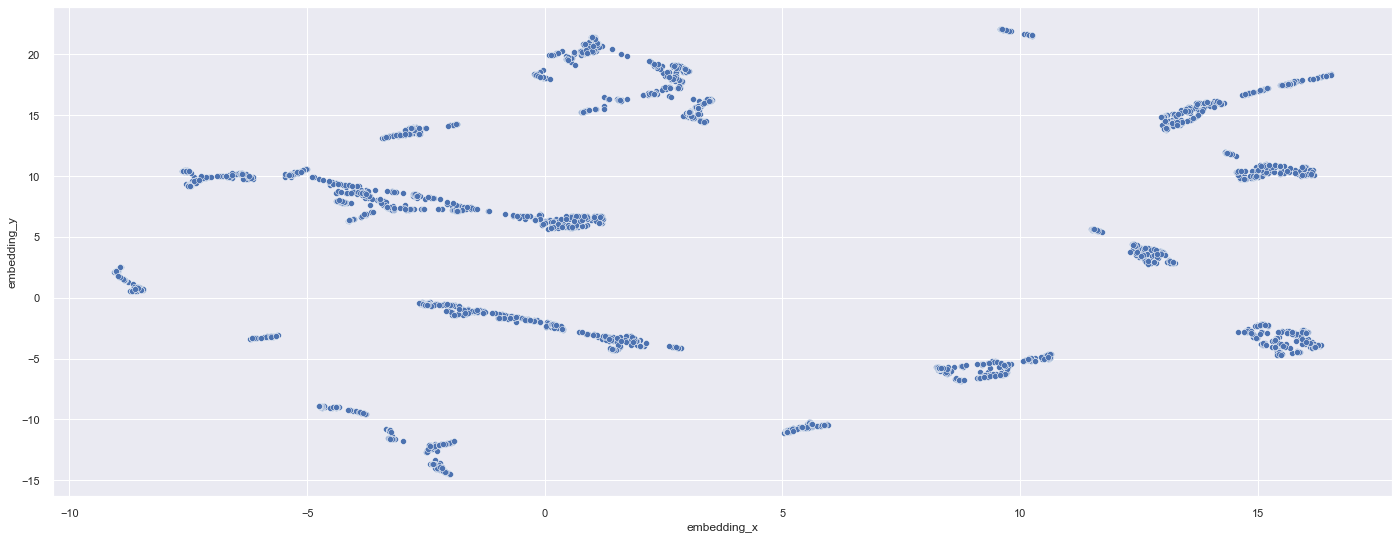

In [97]:
# Reducing dimensionality  # reduce the projection of the 100 columns into 2.
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_leaf)

#embedding
df_tree_v2 = pd.DataFrame()
df_tree_v2['embedding_x'] = embedding[:,0]
df_tree_v2['embedding_y'] = embedding[:,1]

#plotting
sns.scatterplot(x = 'embedding_x',
               y = 'embedding_y',
               data = df_tree_v2)

In [98]:
# Now we run the new space on the data.so people become neighbors because of the gross_revenue.  
# 'so they are neighbors in the embedded space'.
# This works, but wont be able to explain the reason neighbors are neighbors....
# 

# Data Preparation


In [99]:
# df5 = df4.copy()
df5_aux = df4.copy()
df5 = df_tree.copy()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


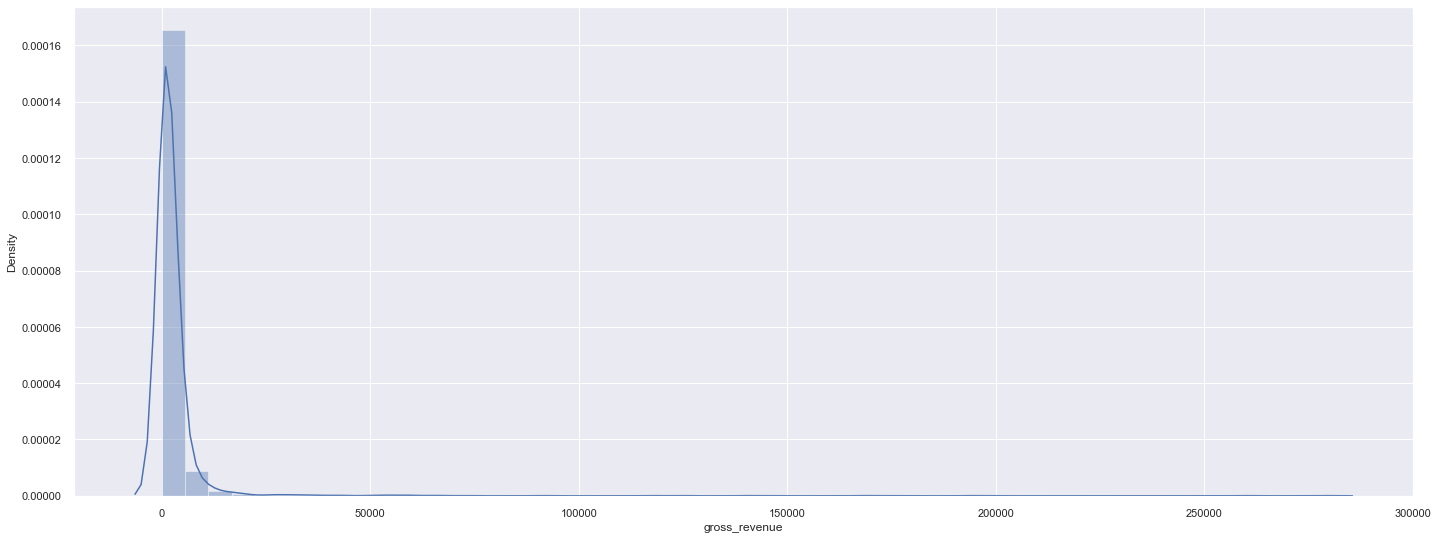

In [100]:

sns.distplot(df5_aux['gross_revenue']);
# Talvez um minmax, tá muito deseguilibrada essa disribuicao.


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='gross_revenue', ylabel='Density'>

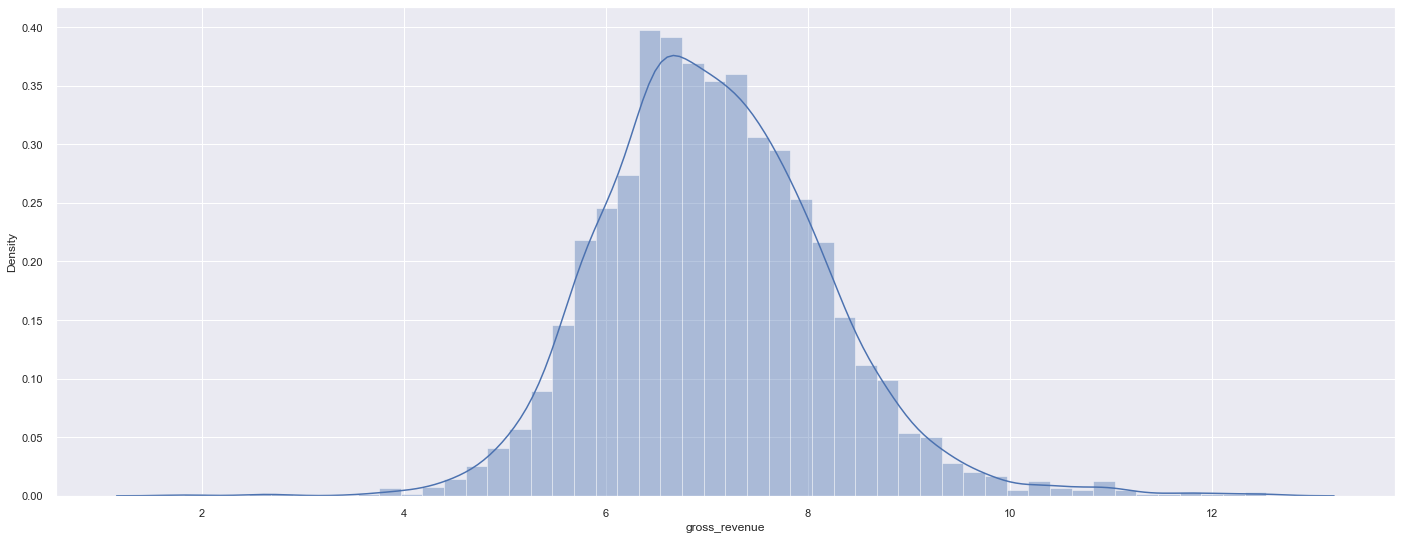

In [101]:
sns.distplot(np.log(df5_aux['gross_revenue']))

In [102]:
# Previously tested transformations before deciding going with embedded spaces:


# # mm = pp.MinMaxScaler()
# # ss = pp.StandardScaler()
# # rs = pp.RobustScaler()

# df5_aux['gross_revenue'] = mm.fit_transform(df5_aux[['gross_revenue']])
# df5_aux['recency_days'] = mm.fit_transform(df5_aux[['recency_days']])
# df5_aux['invoice_ammt'] = mm.fit_transform(df5_aux[['invoice_ammt']])
# df5_aux['item_ammt'] = mm.fit_transform(df5_aux[['item_ammt']])
# df5_aux['n_of_dif_products'] = mm.fit_transform(df5_aux[['n_of_dif_products']])

# # df5_aux['avg_ticket'] = mm.fit_transform(df5_aux[['avg_ticket']])
# # df5_aux['avg_recency_days'] = mm.fit_transform(df5_aux[['avg_recency_days']])

# df5_aux['frequency'] = mm.fit_transform(df5_aux[['frequency']])
# df5_aux['qtt_returns'] = mm.fit_transform(df5_aux[['qtt_returns']])

# # df5_aux['avg_basket_size'] = mm.fit_transform(df5_aux[['avg_basket_size']])
# # df5_aux['avg_unique_basket_size'] = mm.fit_transform(df5_aux[['avg_unique_basket_size']])  

# # avg wont make sense in the end, not looking for avg of the avg in the end.

# variable = 'gross_revenue'

# # ['customer_id', 'gross_revenue', 'recency_days', 'n_of_dif_products', 'frequency', 'qtt_returns']

# Data as it is
# print('Min:{} - Max:{}'.format(df5_aux[variable].min(), df5_aux[variable].max() ) )
# sns.displot(df5_aux[variable]);

# # Data Standardized/Rescaled
# print('Min:{} - Max:{}'.format(df5_aux[variable].min(), df5_aux[variable].max() ) )
# sns.displot(df5_aux[variable]);

In [103]:
# Box Plot
# sns.boxplot(df5_aux[variable]);

# Feature Selection

In [104]:
# Previous cycles:
# cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'n_of_dif_products', 'frequency', 'qtt_returns']

In [105]:
# df6 = df5[cols_selected].copy()
df6 = df_tree.copy()
df6.head()

,embedding_x,embedding_y
0,18.189165,1.047733
1,14.702026,-6.494765
2,16.770378,16.416286
3,-0.536808,1.909567
4,4.409677,21.412285


# Hyperparameter Fine-Tuning

In [106]:
# X = df6.drop(columns = ['customer_id'])
X = df_tree.copy()
X_v2 = df_tree_v2.copy()

In [107]:
X.head()

,embedding_x,embedding_y
0,18.189165,1.047733
1,14.702026,-6.494765
2,16.770378,16.416286
3,-0.536808,1.909567
4,4.409677,21.412285


In [111]:
# clusters = [2, 3, 4, 5, 6, 7 , 8 ,9 ]
clusters = np.arange(2,25,1)

## K-Means

In [112]:

kmeans_list = []
for k in clusters:
    # defining model
    kmeans_model = c.KMeans(n_clusters = k)

    # defining training
    kmeans_model.fit(X)

    # define prediction
    labels = kmeans_model.predict(X)
    # performance
    # Using silhouette inside metrics package.
    kmeans_list.append( m.silhouette_score(X, labels, metric = 'euclidean') )
    

#### v2.0 

kmeans_list_v2 = []
for k in clusters:
    # defining model
    kmeans_model = c.KMeans(n_clusters = k)

    # defining training
    kmeans_model.fit(X_v2)

    # define prediction
    labels = kmeans_model.predict(X_v2)
    # performance
    # Using silhouette inside metrics package.
    kmeans_list_v2.append( m.silhouette_score(X_v2, labels, metric = 'euclidean') )

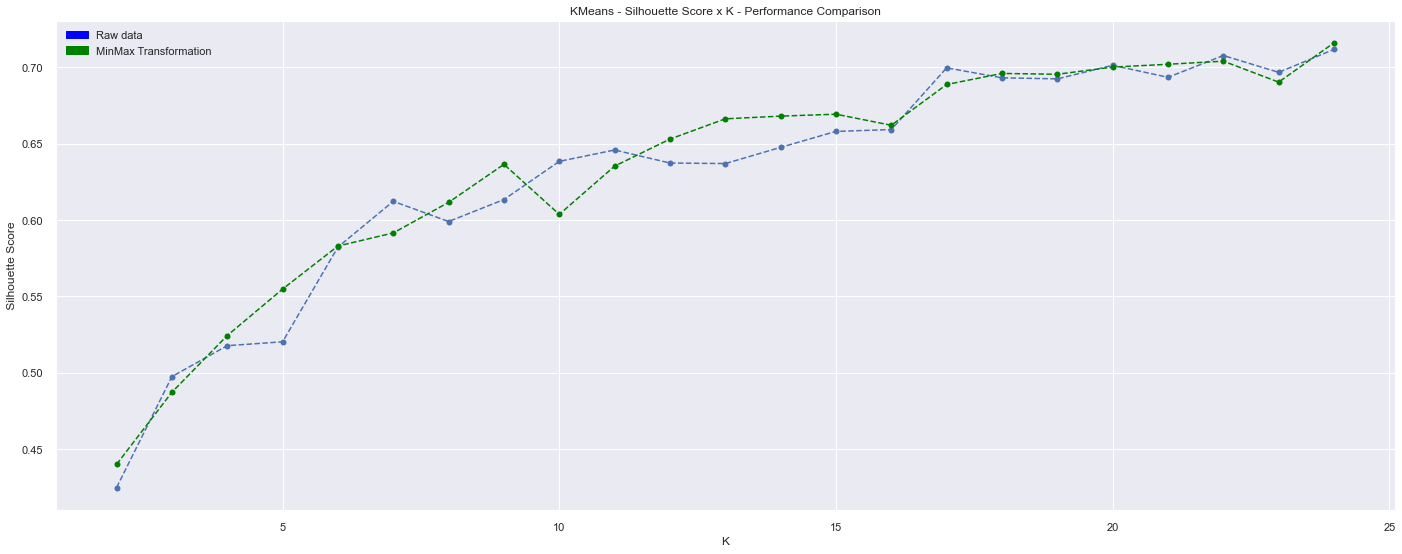

In [113]:
plt.plot(clusters, kmeans_list, linestyle='--', marker = 'o', color ='b')
plt.plot(clusters, kmeans_list_v2, linestyle='--', marker = 'o', color ='green')
plt.xlabel('K')
plt.ylabel(' Silhouette Score ')
plt.title('KMeans - Silhouette Score x K - Performance Comparison')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

blue_patch = mpatches.Patch(color='blue', label='Raw data')
green_patch = mpatches.Patch(color='green', label='MinMax Transformation')

plt.legend(handles=[blue_patch, green_patch])



In [114]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

## GMM

In [115]:
# def, training, predict, score
gmm_list =[]
for k in clusters:
    gmm_model = mx.GaussianMixture(n_components = k)

    gmm_model.fit(X)

    labels = gmm_model.predict(X)

    sil = m.silhouette_score(X, labels, metric = 'euclidean')
    gmm_list.append(sil)

    
### v2.0
gmm_list_v2 =[]
for k in clusters:
    gmm_model = mx.GaussianMixture(n_components = k)

    gmm_model.fit(X_v2)

    labels = gmm_model.predict(X_v2)

    sil = m.silhouette_score(X_v2, labels, metric = 'euclidean')
    gmm_list_v2.append(sil)
    

Text(0.5, 1.0, 'GMM Silhouette Score K')

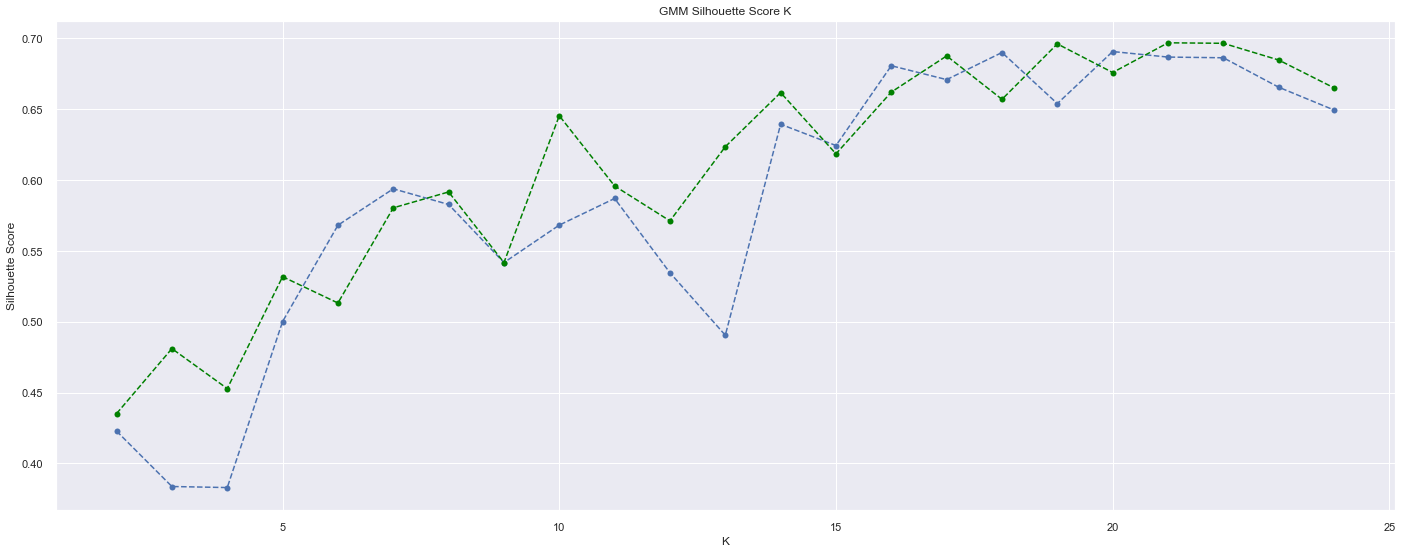

In [116]:
plt.plot(clusters, gmm_list, linestyle='--', marker = 'o', color = 'b')
plt.plot(clusters, gmm_list_v2, linestyle='--', marker = 'o', color = 'green')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('GMM Silhouette Score K')

## Hierarchical Clustering

In [117]:
from scipy.cluster import hierarchy as hc

In [118]:
# model definition and training
hc_model = hc.linkage(X, 'ward')
hc_model_v2 = hc.linkage(X_v2, 'ward')



In [119]:
# DENDROGRAM

# hc.dendrogram(
#     hc_model,
#     leaf_rotation = 90,
#     leaf_font_size = 8)
# plt.plot()

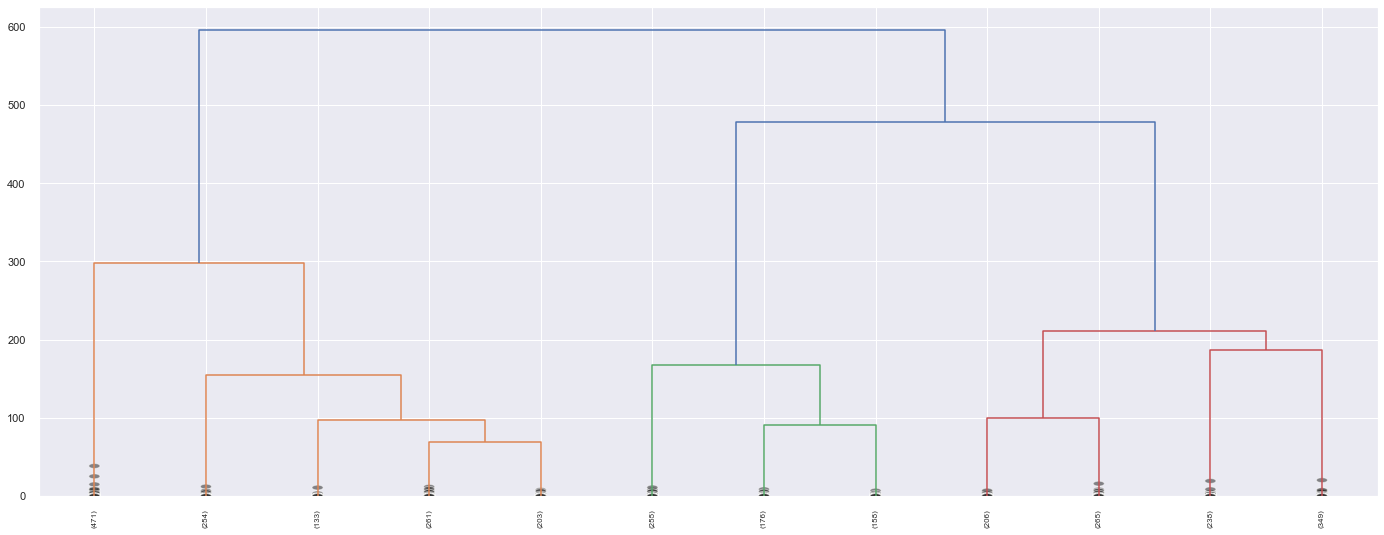

In [120]:
hc.dendrogram(
    hc_model,
    truncate_mode='lastp',
    p=12,
    leaf_rotation = 90,
    leaf_font_size = 8,
    show_contracted = True)
plt.show()

### H-Clustering Silhouette Score

In [121]:
hc_list = []
for k in clusters:
    # def, training, predict score
    hc_model = hc.linkage(X, 'ward')

    # prediction
    labels = hc.fcluster(hc_model, k, criterion = 'maxclust')

    #metrics
    sil = m.silhouette_score(X, labels, metric = 'euclidean')
    hc_list.append( sil )

    
#### v2.0
hc_list_v2 = []
for k in clusters:
    # def, training, predict score
    hc_model_v2 = hc.linkage(X_v2, 'ward')

    # prediction
    labels = hc.fcluster(hc_model_v2, k, criterion = 'maxclust')

    #metrics
    sil = m.silhouette_score(X_v2, labels, metric = 'euclidean')
    hc_list_v2.append( sil )

Text(0, 0.5, '')

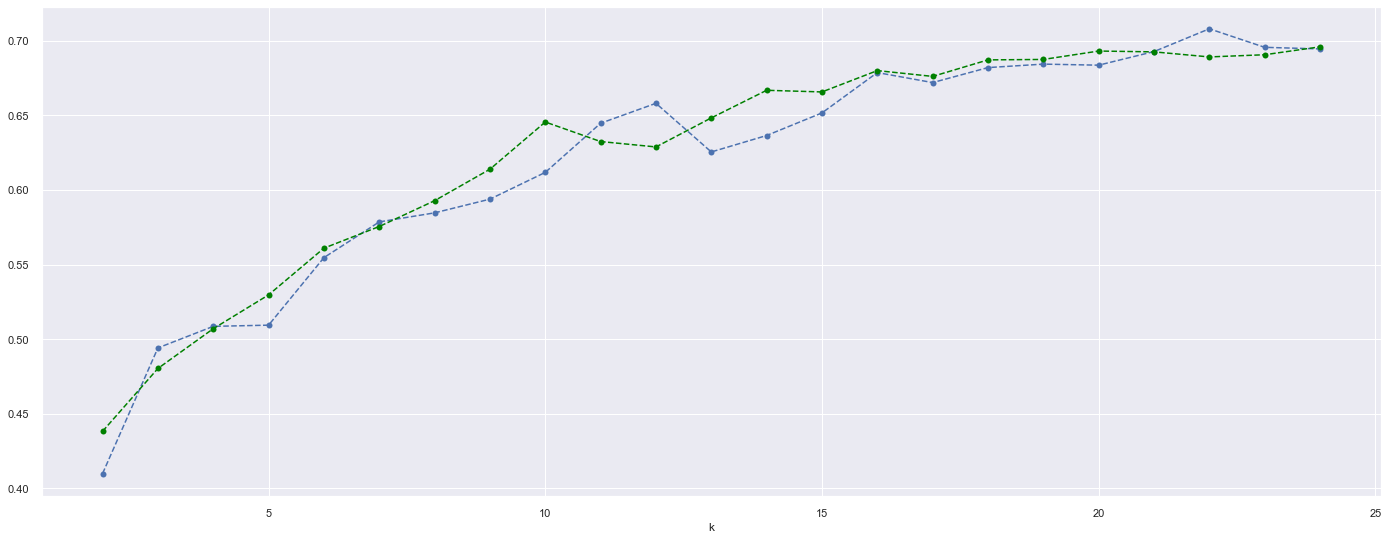

In [122]:
plt.plot(clusters, hc_list, linestyle = '--', marker ='o', color = 'b')
plt.plot(clusters, hc_list_v2, linestyle = '--', marker ='o', color = 'green')
plt.xlabel('k')
plt.ylabel('')

## DBSCAN

In [123]:
eps = 1.2
min_samples = 33
dbscan_model = c.DBSCAN( eps = eps, min_samples = min_samples) 

labels = dbscan_model.fit_predict(X)

db_scan_sil = m.silhouette_score( X, labels, metric = 'euclidean')
sil
print('Silhouette Score {} '.format(db_scan_sil))
print('Clusters inc noisy one (-1) if present: {}'.format(len(unique(labels) )))
print('labels {} '.format(unique(labels)))

print('\n\nVersion2:')
dbscan_model_v2 = c.DBSCAN( eps = eps, min_samples = min_samples) 

labels_v2 = dbscan_model_v2.fit_predict(X_v2)

db_scan_sil_v2 = m.silhouette_score( X_v2, labels, metric = 'euclidean')
sil
print('Silhouette Score {} '.format(db_scan_sil_v2))
print('Clusters inc noisy one (-1) if present: {}'.format(len(unique(labels_v2) )))
print('labels {} '.format(unique(labels)))

Silhouette Score 0.6450983881950378 
Clusters inc noisy one (-1) if present: 15
labels [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] 


Version2:
Silhouette Score 0.6449112892150879 
Clusters inc noisy one (-1) if present: 16
labels [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] 


In [124]:
db_scan_k = len(unique(labels)) - 1


In [125]:
dbscan_list = []

    

### Neighbors issue

In [126]:
neighbors = NearestNeighbors(n_neighbors = min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)

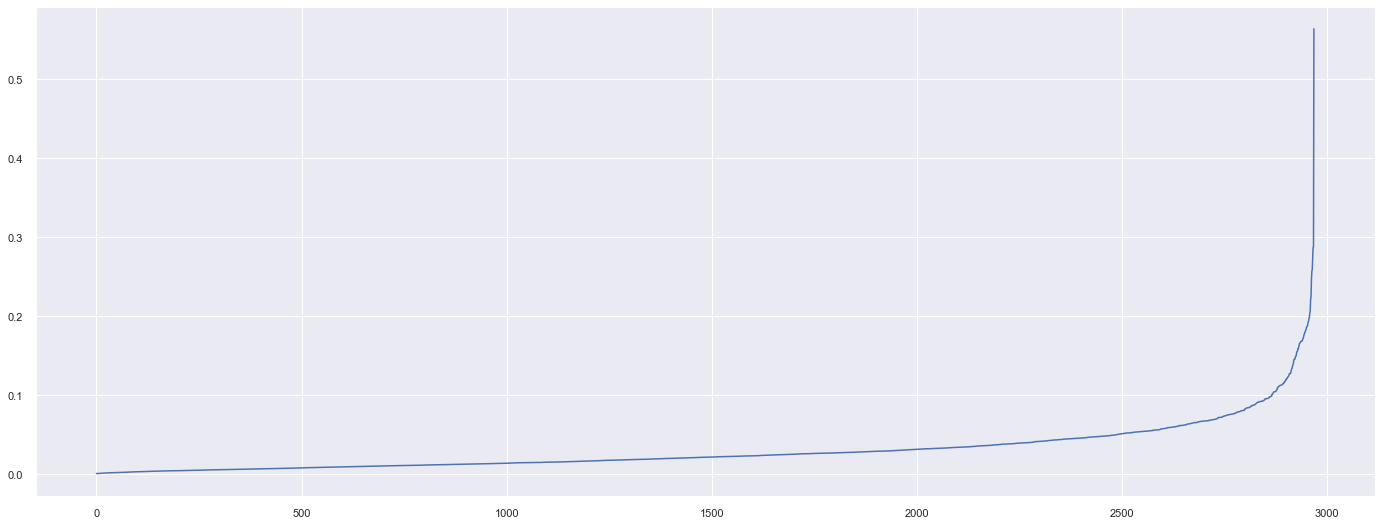

In [127]:
distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.plot(distances)

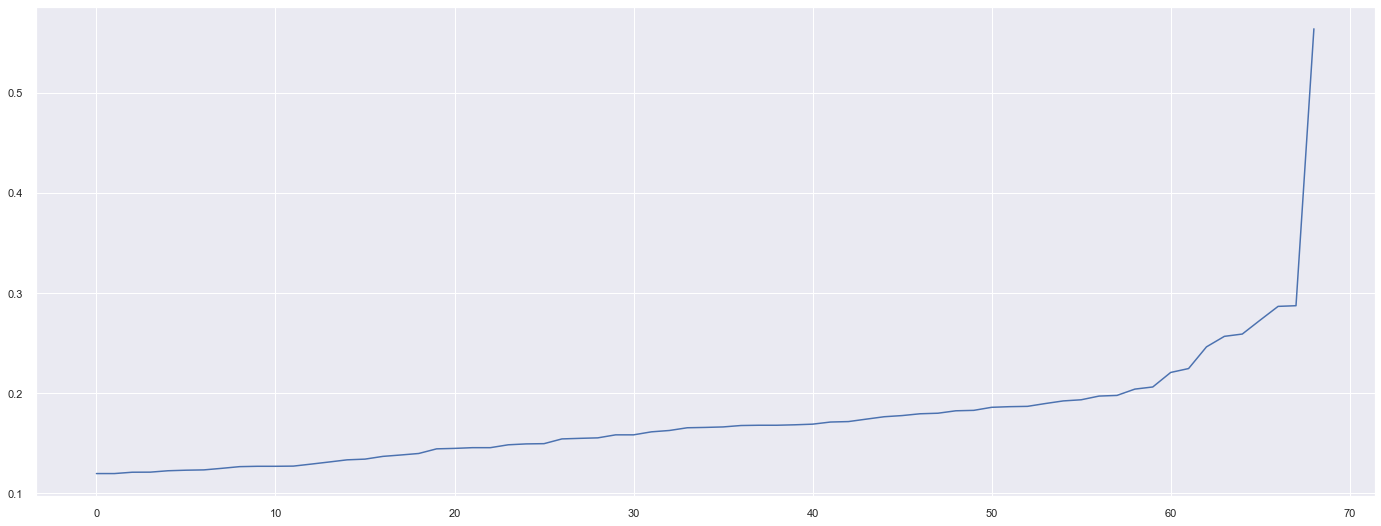

In [128]:
plt.plot(distances[2900:])

In [129]:
labels

array([ 9,  0,  1, ..., 13,  7,  3], dtype=int64)

## RESULTS

In [130]:
df_results = pd.DataFrame(
    {'KMeans':kmeans_list, 'GMM': gmm_list,
     'HCList':hc_list}).T
# todo - include dbscan

dbscan_list = []
for a in (df_results.columns):
    if a != db_scan_k:
        dbscan_list.append(0.0)
    else:
        dbscan_list.append(db_scan_sil)

print(dbscan_list)
    
df_results = pd.DataFrame(
    {'KMeans':kmeans_list, 'GMM': gmm_list,
     'KMeans_v2':kmeans_list_v2, 'GMM_v2': gmm_list_v2,
     'HCList_v2':hc_list_v2,'HCList':hc_list, 'DBScan':dbscan_list}).T

df_results.columns = clusters

df_results.style.highlight_max(color = 'lightgreen', axis = 1)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6450984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.424747,0.497442,0.517701,0.520234,0.582302,0.612274,0.599029,0.613420,0.638437,0.645884,0.637348,0.636988,0.647613,0.658067,0.659261,0.699700,0.693174,0.692469,0.701382,0.693492,0.707779,0.696744,0.711804
GMM,0.422751,0.383650,0.382905,0.500134,0.568136,0.593840,0.582781,0.541748,0.568214,0.587012,0.534557,0.490474,0.639430,0.624395,0.680738,0.670941,0.690083,0.654003,0.690755,0.686850,0.686363,0.665576,0.649473
KMeans_v2,0.439961,0.487186,0.524329,0.554780,0.582976,0.591550,0.611567,0.636492,0.603693,0.635320,0.653018,0.666313,0.668074,0.669330,0.662087,0.688800,0.696034,0.695492,0.700191,0.702042,0.704083,0.690339,0.716109
GMM_v2,0.435147,0.481009,0.452783,0.531788,0.513207,0.580406,0.591624,0.541763,0.645453,0.595844,0.571184,0.623552,0.661766,0.618532,0.662133,0.687671,0.657026,0.696164,0.675947,0.696933,0.696576,0.684779,0.665121
HCList_v2,0.438254,0.480355,0.506989,0.529650,0.560937,0.575455,0.592746,0.613826,0.645453,0.632358,0.628755,0.648204,0.666695,0.665594,0.679882,0.676001,0.687063,0.687365,0.692984,0.692435,0.689046,0.690513,0.695812
HCList,0.409957,0.494111,0.508568,0.509365,0.554608,0.578537,0.584597,0.593781,0.611701,0.644626,0.657972,0.625393,0.636411,0.651536,0.678567,0.671857,0.681906,0.684226,0.683521,0.692629,0.707889,0.695481,0.694408
DBScan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.645098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Script Silhouette

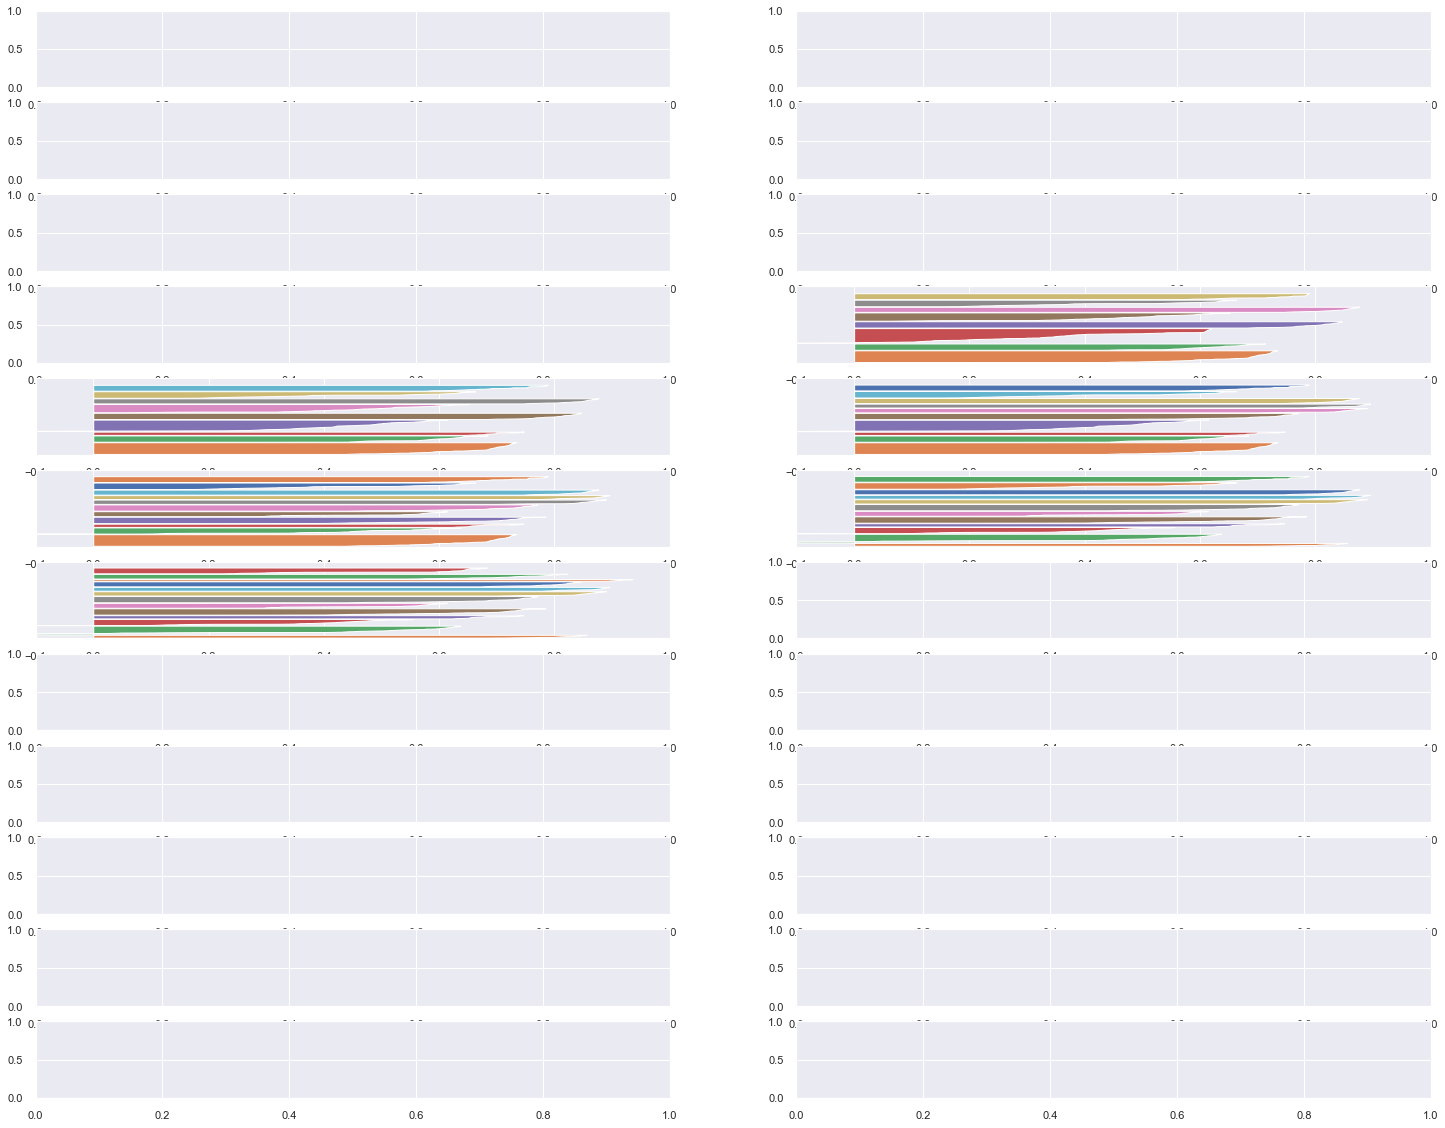

In [240]:

fig, ax = plt.subplots(12,2)
fig.set_size_inches(25,20)  #setting a size for fig

for k in clusters:
    q,mod = divmod(k,2)
    ax[q-1, mod].set_xlim([ -0.1, 1])
    ax[q-1, mod].set_ylim([ 0, len(X) + (k+1)*10])
    #model def
    hc_model = hc.linkage(X, 'ward')

    # predict
    labels = hc.fcluster(hc_model, k, criterion = 'maxclust')

    # performance
    ss = m.silhouette_score(X, labels, metric = 'euclidean')
    print('For k {}, Silhouette Score: {}'.format(k, ss))
    samples_silhouette_values = m.silhouette_samples(X, labels)
    y_lower = 10
    for i in range(k):
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]

        #sorting
        ith_samples_silhouette_values.sort()
        
        # size_cluster
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(i/k)
                


        # fill_betweenx  (matplotlib)

        

        ax[q-1,mod].fill_betweenx( np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        y_lower = y_upper+ 20
    
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # silhouette analysis sklearn - check sklearn suggestions for scripts.
    # plot kmeans silhouette analysis -- check their suggestions
    

## Within-Cluster Sum of Square (WSS)

In [132]:
# trying out diffente cluster values

# clusters = [2, 3, 4, 5, 6, 7 ]
clusters = np.arange(2,14,1)

Text(0.5, 1.0, 'WSS vs K')

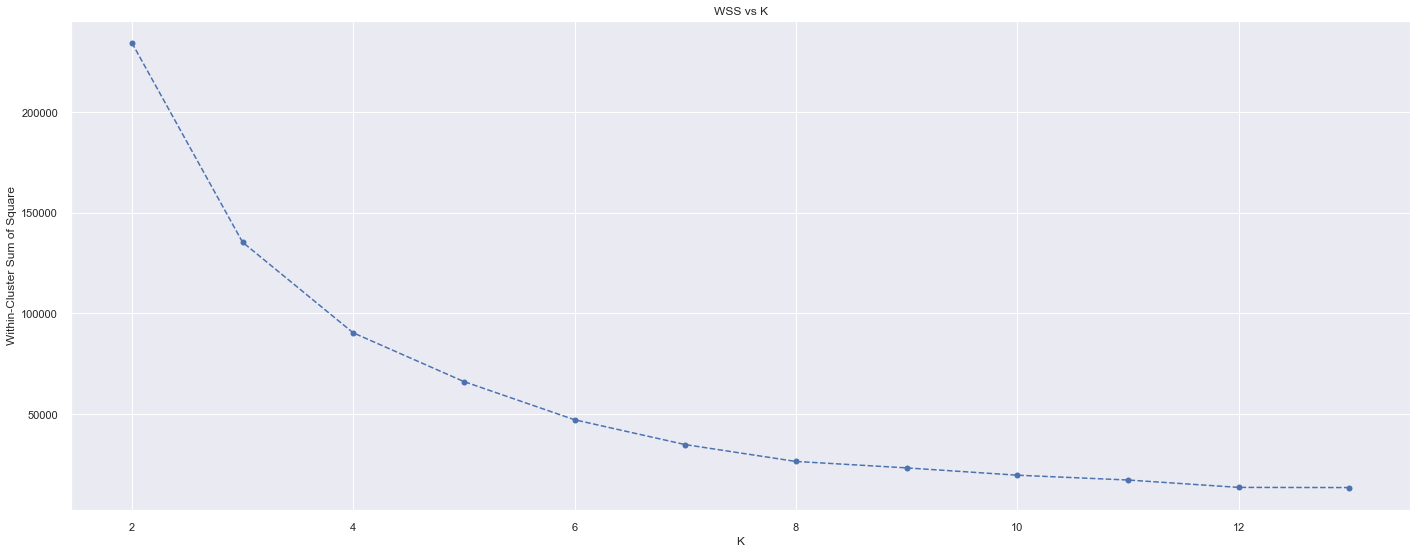

In [133]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans( init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)  # doing centroids at random # n_init, centroid starting times(?)
    # model training
    kmeans.fit(X)
    # validation
    wss.append(kmeans.inertia_)

# plootting wss - ELBOW method # We want to findout the best k before going for the final model
# like a pre-training model.
# This graph is supposed to look like an elbow... (?)
# Supposed to choose the point in the graph where the changes(The angle) most significative happen in this case
# happens where K = 3 and 5 - it is up to the Data Scientist to choose the best point.b

plt.plot(clusters, wss, linestyle = '--', marker ='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS vs K')

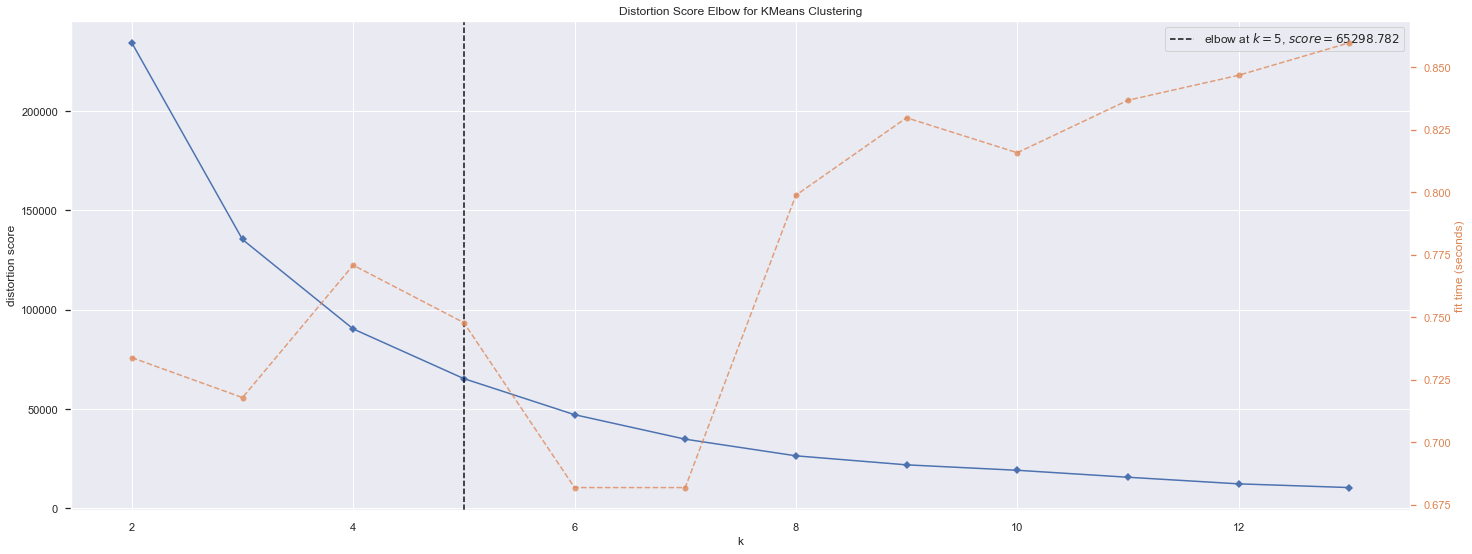

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [134]:
# Choosing K using a more elegant way, using the library yellowbrick
from yellowbrick.cluster import KElbowVisualizer
# !pip install yellowbrick.cluster

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timing = False)
kmeans.fit(X)
kmeans.show()  # it draws the method and tells you the best k value...

# There is also the knee method....

## Sillhouette Score

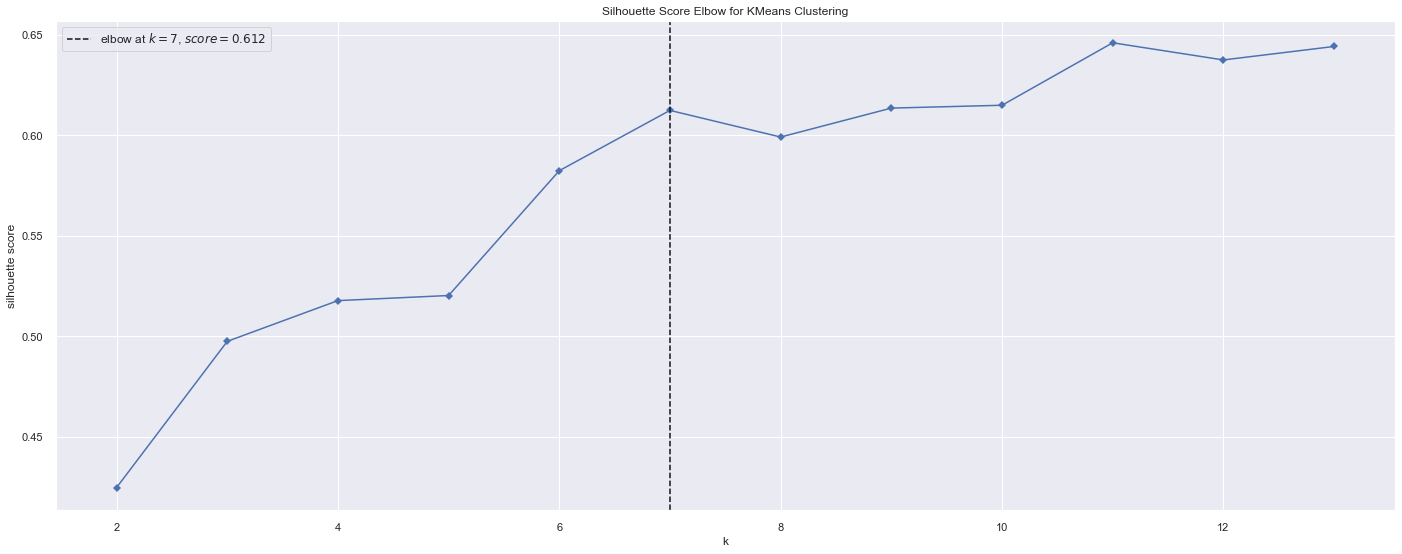

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [135]:
kmeans_si = KElbowVisualizer(c.KMeans(), k=clusters, metric = 'silhouette', timings = False)
kmeans_si.fit(X)
kmeans_si.show()

## Silhouette Analysis

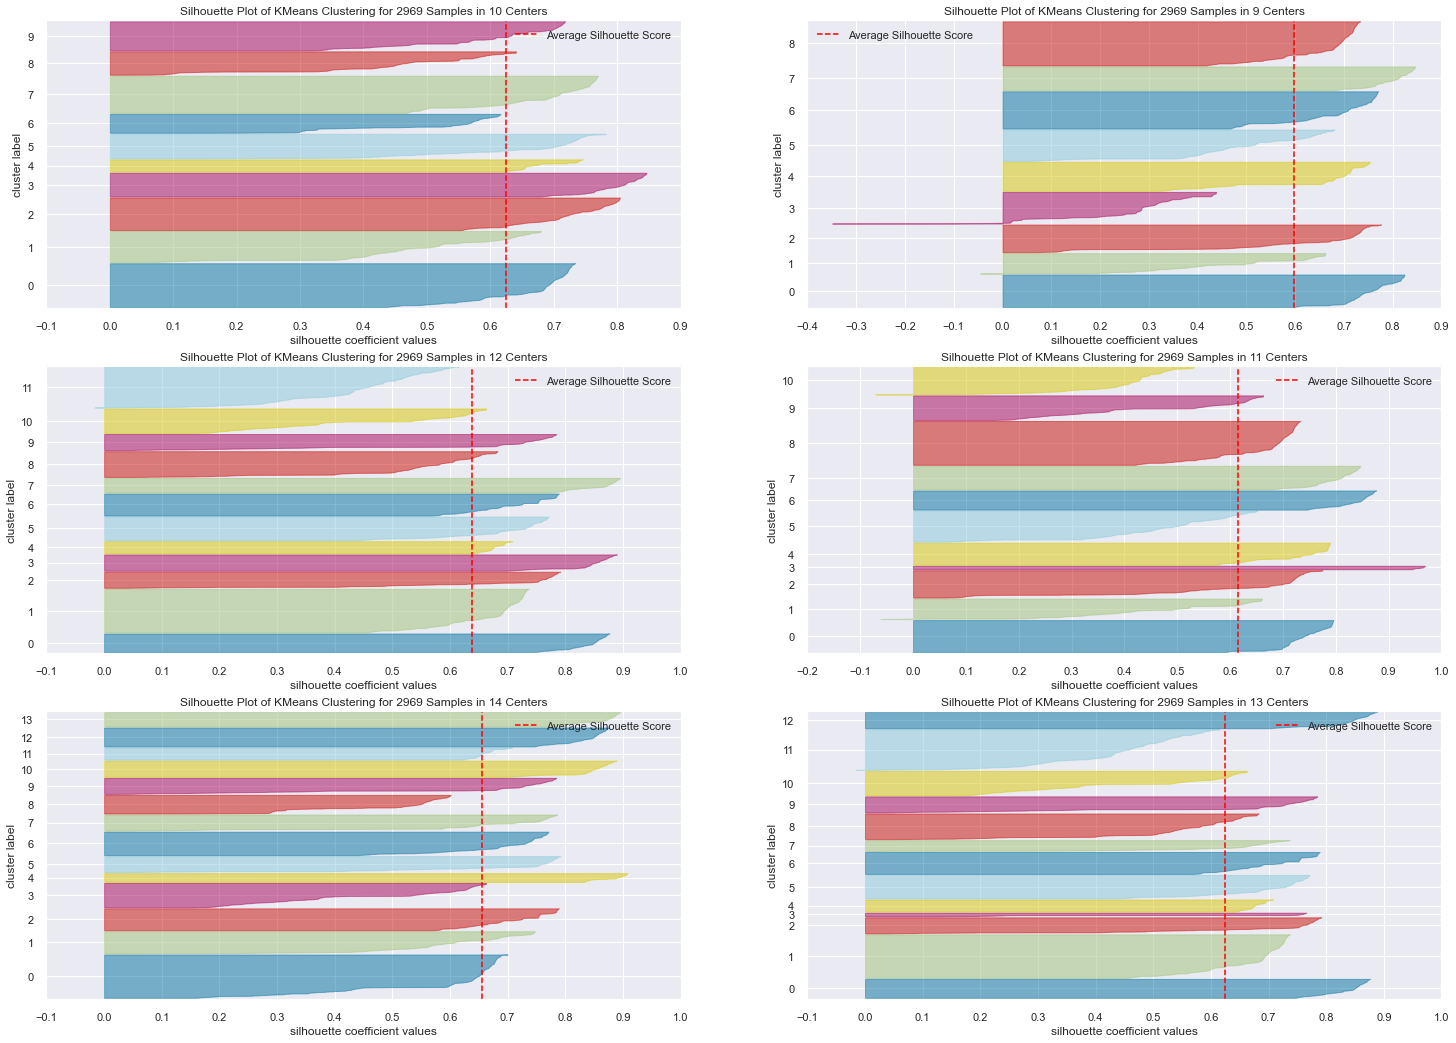

In [136]:
clusters = [9,10,11,12,13,14]

fig, ax = plt.subplots(3,2, figsize = (25,18))
pos = 1
posi = 1
for k in clusters:
    km = c.KMeans(n_clusters = k, init = 'random', n_init = 10, max_iter = 100, random_state = 42)
    q, mod = divmod(k, 2)
    # visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick') #, ax=[0][0])
    # visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax=ax[q-1][mod])

    visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax=ax[posi - 1][mod])
    
    if pos % 2 == 0:
        posi += 1
    pos += 1
    
    visualizer.fit(X)
    visualizer.finalize()

Silhouette now giving us much insight on the number of clusters. A lot more organized after opting for the embedded tree space.

# Model Training

## K-Means

In [137]:
# model definition
# Opting for 11 - it is not the optimum division, however 
# in terms of business and RFM goal, makes sense to go with a lower number,
# silhouette score not bad with 11.

k = 11
kmeans = c.KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)

# model training
kmeans.fit(X)

# clustering
# labels = kmeans.predict(X)
labels = kmeans.labels_


## Cluster Validation

In [138]:
from sklearn import metrics as m

In [139]:
# WSS (Whithin Cluster Sum of Squares)
print( f'WSS Value: {kmeans.inertia_}')

# SS ( Silhouette Score)
print(f'SS Value: {m.silhouette_score(X, labels, metric = "euclidean")}')

WSS Value: 17223.318359375
SS Value: 0.6153544187545776


# Cluster Analysis

## Visual Inspection

In [140]:
# df9 = df6.copy()
df9 = X.copy()
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,18.189165,1.047733,5
1,14.702026,-6.494765,6
2,16.770378,16.416286,7
3,-0.536808,1.909567,10
4,4.409677,21.412285,8


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

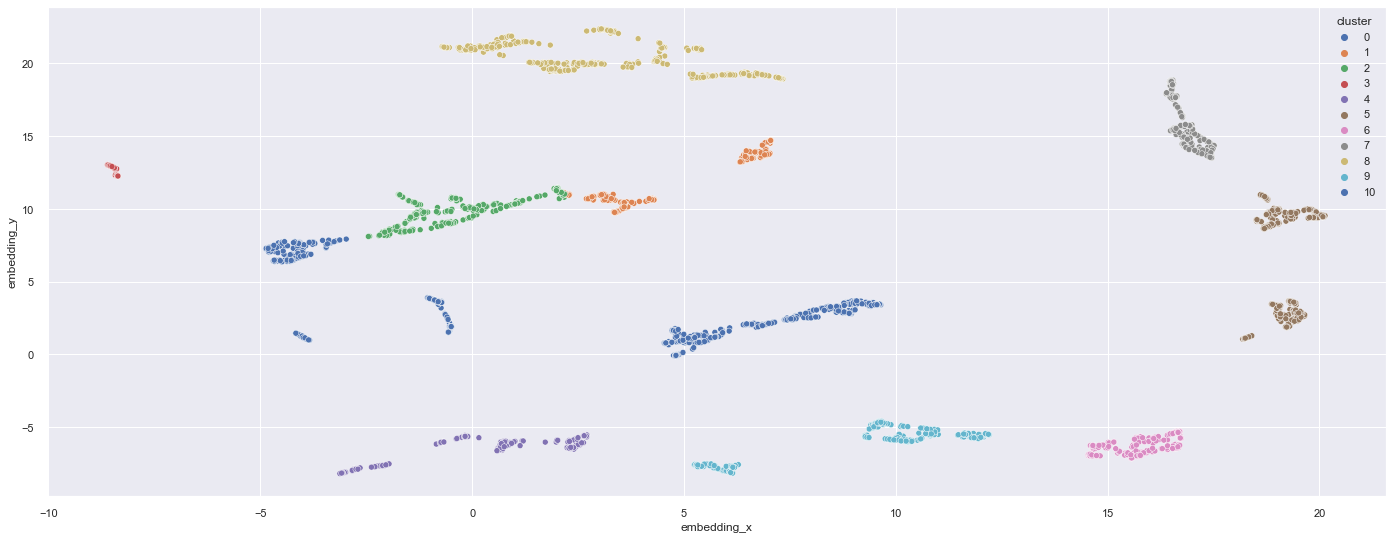

In [141]:
sns.scatterplot( x = 'embedding_x', y = 'embedding_y', data = df9, hue = 'cluster', palette = 'deep')

### Multi-Feature

C:\Users\Fu\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


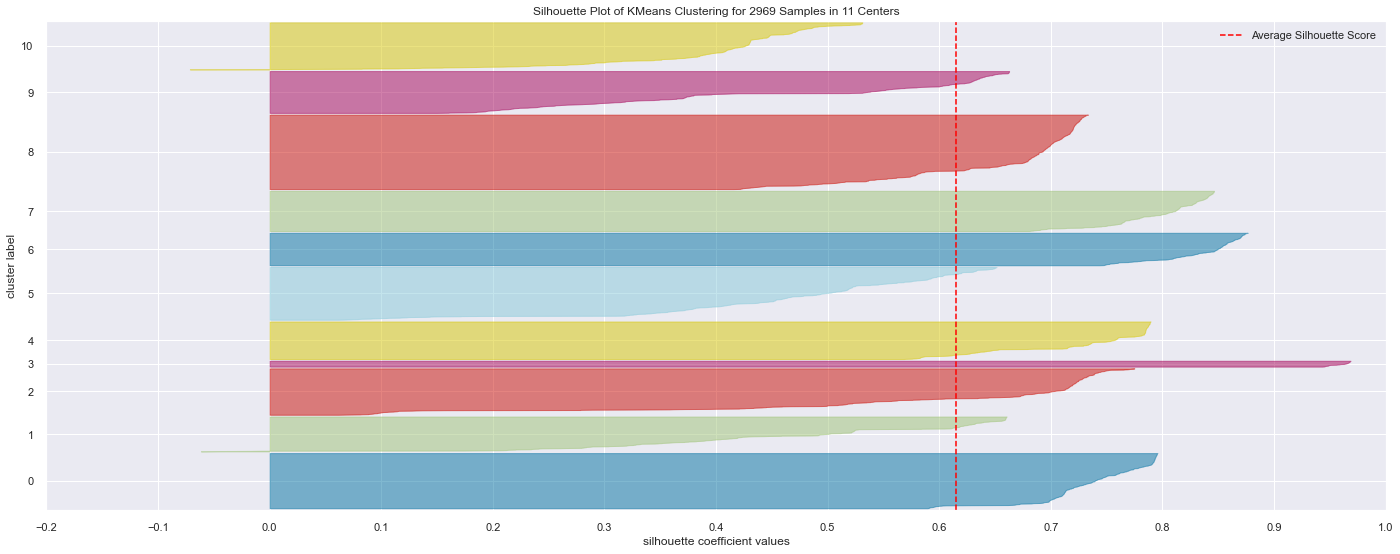

In [142]:
visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### 2d plot

In [143]:
df9.columns

Index(['embedding_x', 'embedding_y', 'cluster'], dtype='object')

In [144]:
# df_viz = df9.drop(columns = 'customer_id', axis = 1)
# sns.pairplot(df_viz, hue = 'cluster')

### UMAP - t-SNE

In [145]:
# Manifold
# UMAP, t-SNE(2009) - MAnifold - Topology


In [146]:
# UMAP
# reducer = umap.UMAP(n_neighbors = 9, random_state = 42)
# reducer = umap.UMAP(random_state = 42)
# embedding = reducer.fit_transform(X)

# embedding
# df_viz['embedding_x'] = embedding[:,0]
# df_viz['embedding_y'] = embedding[:,1]

#plotting umap
# sns.scatterplot( x = 'embedding_x', y = 'embedding_y', 
#                 hue = 'cluster', 
#                 palette = sns.color_palette('hls', n_colors = len( df_viz['cluster'].unique() ) ), data = df_viz )

### 3 features 3d.

In [147]:


# fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z = 'gross_revenue', color = 'cluster')
# fig.show()

## Cluster Profile


In [148]:
df9.head()

,embedding_x,embedding_y,cluster
0,18.189165,1.047733,5
1,14.702026,-6.494765,6
2,16.770378,16.416286,7
3,-0.536808,1.909567,10
4,4.409677,21.412285,8


In [195]:
df4.gross_revenue.sum()

8162736.159999999

In [194]:

df9_aux = df4.copy()
df9_aux['cluster'] = labels

# Number of Customers
df_cluster = (df9_aux[['customer_id', 'cluster']].groupby('cluster').count().reset_index())
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Centroids - the group mean. 

# Avg Gross Revenue
df_avg_gross_revenue = (df9_aux[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index())
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, on = 'cluster', how = 'left')

# Avg recency days
df_avg_recency_days = (df9_aux[['recency_days', 'cluster']].groupby('cluster').mean().reset_index())
df_cluster = pd.merge(df_cluster, df_avg_recency_days, on = 'cluster', how = 'left')

# Avg invoices number
df_inv = (df9_aux[['n_of_dif_products', 'cluster']].groupby('cluster').mean().reset_index())
df_cluster = pd.merge(df_cluster, df_inv, on = 'cluster', how = 'left')

# Frequency
df_fre = (df9_aux[['frequency', 'cluster']].groupby('cluster').mean().reset_index())
df_cluster = pd.merge(df_cluster, df_fre, on = 'cluster', how = 'left')

# Returns
df_ret = (df9_aux[['qtt_returns', 'cluster']].groupby('cluster').mean().reset_index())
df_cluster = pd.merge(df_cluster, df_ret, on = 'cluster', how = 'left')

df_cluster


,cluster,customer_id,perc_customer,gross_revenue,recency_days,n_of_dif_products,frequency,qtt_returns
0,0,349,11.754800,1064.457135,66.687679,71.959885,0.051469,12.553009
1,1,221,7.443584,546.361810,90.221719,45.977376,0.075763,6.004525
2,2,294,9.902324,620.276939,84.183673,50.302721,0.066254,4.676871
3,3,38,1.279892,68280.195263,15.684211,1089.157895,0.156863,3320.368421
4,4,238,8.016167,1660.996303,32.764706,124.747899,0.036174,17.235294
5,5,334,11.249579,3425.631317,31.925150,202.311377,0.041720,33.062874
6,6,206,6.938363,2354.410922,43.116505,153.126214,0.037805,18.029126
7,7,255,8.588750,7760.927451,22.698039,336.725490,0.077621,81.882353
8,8,471,15.863927,335.489214,118.690021,22.048832,0.111224,5.414013
9,9,265,8.925564,1768.837434,49.275472,105.890566,0.040698,25.513208


X -> Insiders,

X -> Needs to improve frequency

X -> ....

In [150]:
df_cluster['frequency_min_max'] = mm.fit_transform(df_cluster[['frequency']])
df_cluster['recency_min_max'] = mm.fit_transform(df_cluster[['recency_days']])
df_cluster['recency_min_max'] = 1 - df_cluster['recency_min_max']
df_cluster['bubble'] = df_cluster.gross_revenue // 10
df_cluster.loc[3, 'bubble'] = 1400.0

In [151]:
df_cluster.sort_values('gross_revenue', ascending = False)
df_cluster['gross_revenue_log'] = np.log10(df_cluster['gross_revenue'])

<AxesSubplot:xlabel='recency_min_max', ylabel='frequency_min_max'>

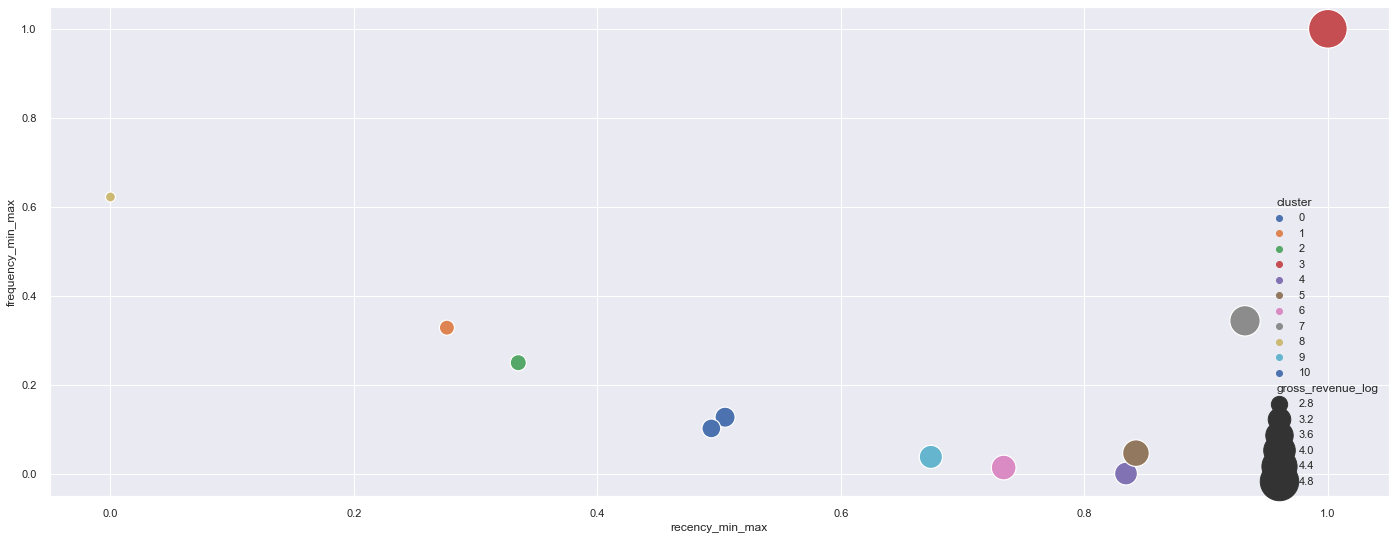

In [152]:
sns.scatterplot( x = 'recency_min_max', y = 'frequency_min_max', data = df_cluster, hue = 'cluster', palette = 'deep', size = 'gross_revenue_log', sizes = (100,1500) )

In [153]:
cluster_names = {
    3 : 'Champion - Insiders',
    7 : 'Loyal Customers',
    5 : 'Promising recent 1',
    4 : 'Promising recent 2',
    6 : 'Promising 3',
    9 : 'Attention needed - about to sleep',
    0 : 'Attention needed 1',
    10 :'Attention needed 2',
    1 : 'Hybernating 1',
    2 : 'Hybernating 2',
    8 : 'About to lose'}
df_cluster['cluster_name'] = df_cluster['cluster'].map(cluster_names)

In [154]:
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,n_of_dif_products,frequency,qtt_returns,frequency_min_max,recency_min_max,bubble,gross_revenue_log,cluster_name
0,0,349,11.754800,1064.457135,66.687679,71.959885,0.051469,12.553009,0.126727,0.504849,106.0,3.027128,Attention needed 1
1,1,221,7.443584,546.361810,90.221719,45.977376,0.075763,6.004525,0.328019,0.276376,54.0,2.737480,Hybernating 1
2,2,294,9.902324,620.276939,84.183673,50.302721,0.066254,4.676871,0.249230,0.334994,62.0,2.792586,Hybernating 2
3,3,38,1.279892,68280.195263,15.684211,1089.157895,0.156863,3320.368421,1.000000,1.000000,1400.0,4.834295,Champion - Insiders
4,4,238,8.016167,1660.996303,32.764706,124.747899,0.036174,17.235294,0.000000,0.834179,166.0,3.220369,Promising recent 2
5,5,334,11.249579,3425.631317,31.925150,202.311377,0.041720,33.062874,0.045948,0.842330,342.0,3.534741,Promising recent 1
6,6,206,6.938363,2354.410922,43.116505,153.126214,0.037805,18.029126,0.013509,0.733682,235.0,3.371882,Promising 3
7,7,255,8.588750,7760.927451,22.698039,336.725490,0.077621,81.882353,0.343421,0.931908,776.0,3.889914,Loyal Customers
8,8,471,15.863927,335.489214,118.690021,22.048832,0.111224,5.414013,0.621847,0.000000,33.0,2.525679,About to lose
9,9,265,8.925564,1768.837434,49.275472,105.890566,0.040698,25.513208,0.037483,0.673890,176.0,3.247688,Attention needed - about to sleep


<AxesSubplot:xlabel='recency_min_max', ylabel='frequency_min_max'>

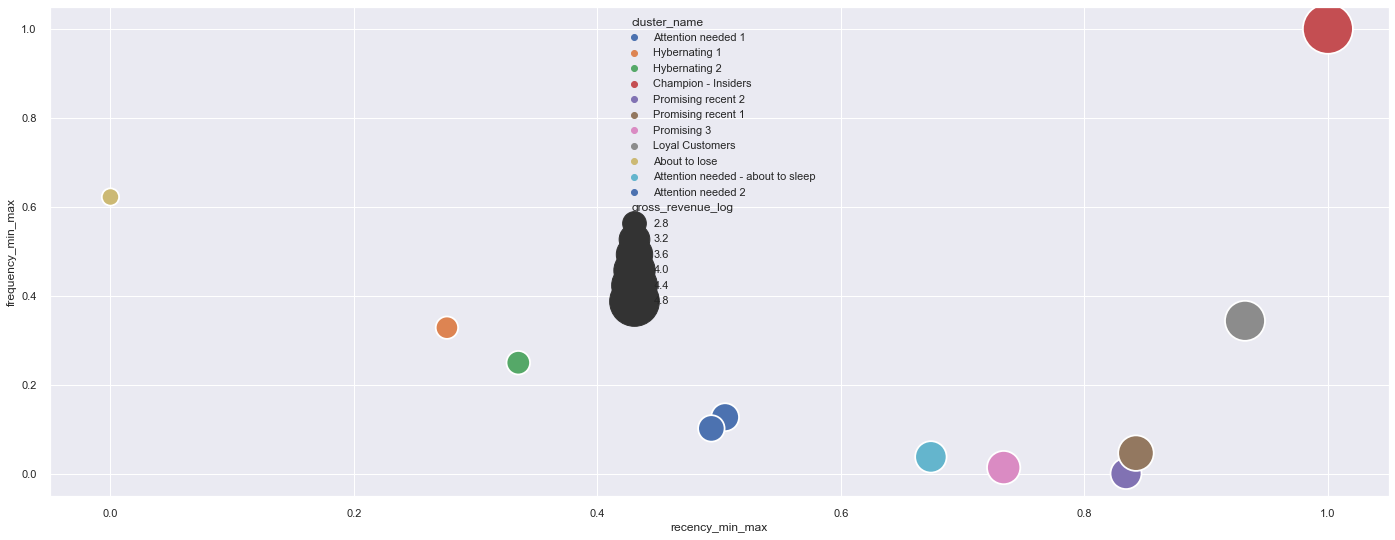

In [155]:
sns.scatterplot( x = 'recency_min_max', y = 'frequency_min_max', data = df_cluster, hue = 'cluster_name', palette = 'deep', size = 'gross_revenue_log', sizes = (300,2500) )

### Cluster Synthesis

In [156]:
df_cluster.columns

Index(['cluster', 'customer_id', 'perc_customer', 'gross_revenue',
       'recency_days', 'n_of_dif_products', 'frequency', 'qtt_returns',
       'frequency_min_max', 'recency_min_max', 'bubble', 'gross_revenue_log',
       'cluster_name'],
      dtype='object')

In [176]:
df_cluster.columns = ['cluster', 'number_of_customers', 'perc_customer', 'gross_revenue',
       'recency_days', 'n_of_dif_products', 'frequency', 'qtt_returns',
       'frequency_min_max', 'recency_min_max', 'aux_bubble', 'gross_revenue_log','cluster_name'
       ]

In [177]:
df_cluster_rep = df_cluster.sort_values('cluster').reset_index(drop = True)

for i in range(len(np.unique(df_cluster_rep['cluster']))):
    print('Cluster {}: "{}"'.format(df_cluster_rep.loc[i, 'cluster'], df_cluster_rep.loc[i, 'cluster_name']))
    print(' - Number of customers {} ({:,.2f} % of total)'.format(df_cluster_rep.loc[i, 'number_of_customers'], df_cluster_rep.loc[i, 'perc_customer']) )
    print(' - Average amount spent in total ${:,.2f} '.format(df_cluster_rep.loc[i, 'gross_revenue']) )
    print(' - Average Recency (days) {:,.2f} \n'.format(df_cluster_rep.loc[i, 'recency_days']) )

Cluster 0: "Attention needed 1"
 - Number of customers 349 (11.75 % of total)
 - Average amount spent in total $1,064.46 
 - Average Recency (days) 66.69 

Cluster 1: "Hybernating 1"
 - Number of customers 221 (7.44 % of total)
 - Average amount spent in total $546.36 
 - Average Recency (days) 90.22 

Cluster 2: "Hybernating 2"
 - Number of customers 294 (9.90 % of total)
 - Average amount spent in total $620.28 
 - Average Recency (days) 84.18 

Cluster 3: "Champion - Insiders"
 - Number of customers 38 (1.28 % of total)
 - Average amount spent in total $68,280.20 
 - Average Recency (days) 15.68 

Cluster 4: "Promising recent 2"
 - Number of customers 238 (8.02 % of total)
 - Average amount spent in total $1,661.00 
 - Average Recency (days) 32.76 

Cluster 5: "Promising recent 1"
 - Number of customers 334 (11.25 % of total)
 - Average amount spent in total $3,425.63 
 - Average Recency (days) 31.93 

Cluster 6: "Promising 3"
 - Number of customers 206 (6.94 % of total)
 - Average 

## Hypothesis Testing

### MindMap

In [223]:
df10 = df9_aux.copy()
df10.head()
df10['cluster_name'] = df_cluster['cluster'].map(cluster_names)

- Modeling the phenomena.
- Understanding entities (customer, location, family, income)
- Entity properties (eg. customer: income, education, age group, etc)


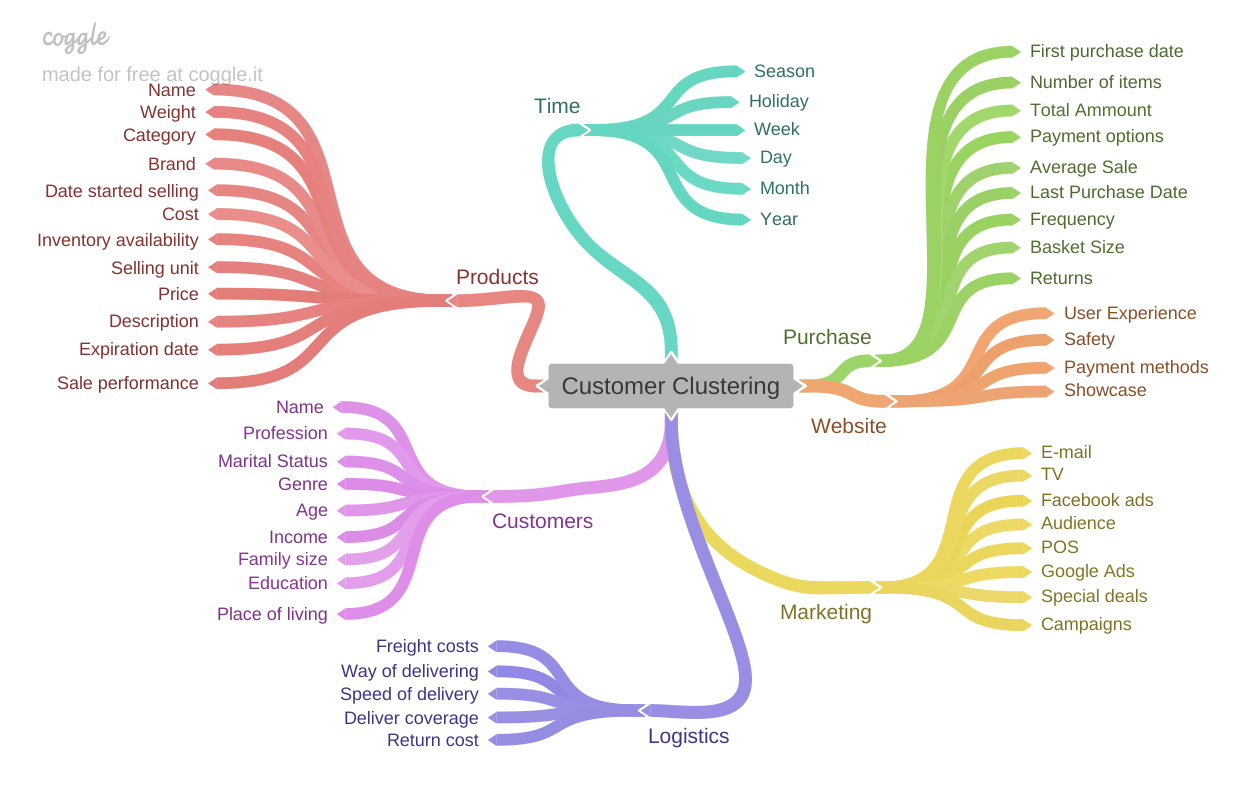

In [160]:
from IPython.core.display import Image
Image('./mindmap.png')

### Hypothesis Purchases: 

#### Insiders cluster customers represent more than 20% of total revenue.

In [161]:
insiders = df10.loc[df10['cluster'] == 3, 'gross_revenue'].sum()
# df_sales_not_insiders = df10.loc[df10['cluster'] == 3, 'item_ammt'].median()
total =df10.loc[:, 'gross_revenue'].sum()
print ( 'insiders / total: {:.2f}%'.format(insiders / total * 100) )

insiders / total: 31.79%


TRUE. Insiders represent more than 30% of gross revenue

####  Customers in the Insiders cluster have a number of returns below the average of the total customer base.


In [178]:
# avg returns inside
df_avg_return_insiders = df10.loc[df10['cluster'] == 3, 'qtt_returns'].mean()

# avg return total
df_avg_return_all = df10['qtt_returns'].mean()

#
print( 'Avg Return Insiders: {} vs Avg Return All:{}'.format( np.round( df_avg_return_insiders, 0 ), 
                                                              np.round( df_avg_return_all, 0 ) ) )

Avg Return Insiders: 3320.0 vs Avg Return All:62.0


FALSE. Average return for insiders are higher.

#### Cheaper products are more transactioned than expensive ones.

In [180]:


bins = list(range(0,1100,100))
df2['binned_price'] = pd.cut(df2['unit_price'], bins=bins)

aux2 = df2[['unit_price','binned_price']].groupby('binned_price').count().reset_index()
# plt.subplot(1,3,2)
# sns.barplot(x = 'binned_price', y = 'unit_price', data = aux2)
aux2.columns = ['binned_price', 'transactions_ammt']
aux2

,binned_price,transactions_ammt
0,"(0, 100]",535996
1,"(100, 200]",123
2,"(200, 300]",11
3,"(300, 400]",2
4,"(400, 500]",5
5,"(500, 600]",1
6,"(600, 700]",3
7,"(700, 800]",0
8,"(800, 900]",0
9,"(900, 1000]",1


TRUE. Most of transactions comprehend products up to 100 euros.

#### Customers in the Insiders program account for more than 30% of company gross revenue.

In [230]:
# defining dataset with cluster names
# names = {"4" : "Insiders", "1" : "Potential Loyalists", "0" : "Loyal Customers", "2" : "Promissing 1", "8" : "Need Attention 1", "6" : "Promising 2", "7" : "Need Attention 2", "5" : "Hibernating 1", "10" : "Churn 1", "3" : "Price Sensitive", "9" : "Churn 2", "11" : "Hibernating 2", "-1" : 'Noise' }


# summing revenue by cluster
df_agg = df10[['cluster', 'gross_revenue']].copy()
df_agg = df_agg.groupby('cluster').sum().reset_index()
df_agg['cluster_name'] = df_agg['cluster'].map(cluster_names)
# df_agg

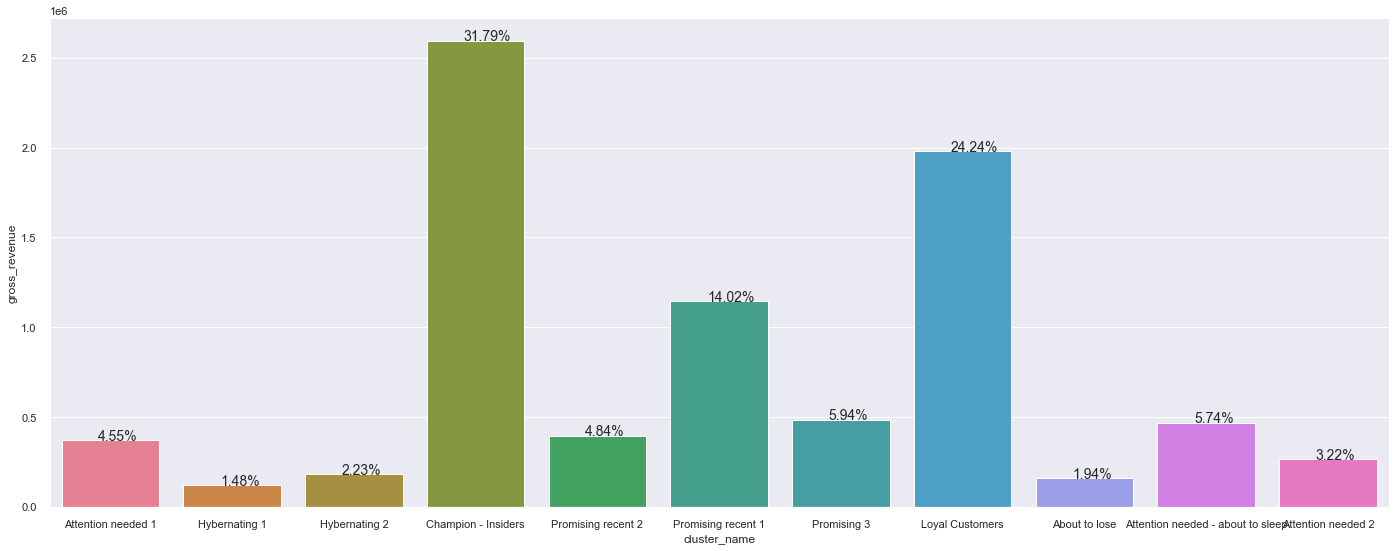

In [231]:
# ploting the results
bar = sns.barplot(data = df_agg, x = 'cluster_name', y = 'gross_revenue', palette = 'husl');

bar_order = list(df_agg['cluster_name'].unique())
spots = zip(bar.patches, bar_order)
for spot in spots:
    total = df_agg['gross_revenue'].sum()
    class_total = df_agg[df_agg['cluster_name'] == spot[1]]['gross_revenue']
    
    percent = float(class_total/total*100)

    height = spot[0].get_height()
    bar.text(spot[0].get_x()+0.3, height+5, '{:.2f}%'.format(percent), fontsize = 14 )


TRUE. They account for almost 31,79%.

### Business questions

#### Who are the people elegible for the Insiders program?

In [236]:
insiders_id = list(df10.loc[df10['cluster'] == 3, 'customer_id'])
print(insiders_id)

[15311, 16029, 17511, 13408, 13694, 12748, 14911, 17841, 13777, 17381, 15061, 14156, 13798, 14680, 16013, 17949, 15769, 13081, 13089, 16422, 17450, 15838, 18102, 17857, 14298, 17404, 16684, 12931, 14646, 13027, 12415, 15749, 14088, 13098, 16333, 12901, 16446, 14096]


#### How many people are part of this group?

In [237]:
print(df10.loc[df10['cluster'] == 3, 'customer_id'].size)

38


In [174]:
df10.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'invoice_ammt',
       'item_ammt', 'n_of_dif_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qtt_returns', 'avg_basket_size', 'avg_unique_basket_size',
       'cluster', 'cluster_name'],
      dtype='object')

#### What are the main characteristics of the insiders group?

In [239]:
print(f"Total Number of Insiders: {len(df10.loc[df10['cluster'] == 3, 'customer_id'])} out of {len(df10['customer_id'])}")
print(f"Average Gross Revenue Insiders: {df10.loc[df10['cluster'] == 3, 'gross_revenue'].mean():.2f}, Overall: {df10['gross_revenue'].mean():.2f}")
print(f"Median Gross Revenue Insiders: {df10.loc[df10['cluster'] == 3, 'gross_revenue'].median():.2f}, Overall: {df10['gross_revenue'].median():.2f}")
print(f"Average Recency Insiders: {df10.loc[df10['cluster'] == 3, 'recency_days'].mean():.2f}, Overall: {df10['recency_days'].mean():.2f}")
print(f"Average Frequency Insiders: {df10.loc[df10['cluster'] == 3, 'frequency'].mean():.2f}, Overall: {df10['frequency'].mean():.2f}")
print(f"Average different products purchased Insiders: {df10.loc[df10['cluster'] == 3, 'avg_basket_size'].mean():.2f}, Overall: {df10['avg_basket_size'].mean():.2f}")


Total Number of Insiders: 38 out of 2969
Average Gross Revenue Insiders: 68280.20, Overall: 2749.32
Median Gross Revenue Insiders: 47513.06, Overall: 1086.92
Average Recency Insiders: 15.68, Overall: 64.29
Average Frequency Insiders: 0.16, Overall: 0.06
Average different products purchased Insiders: 2289.02, Overall: 249.81


# Deploy to production